#### Rutas

In [36]:
from setup import set_project_root
set_project_root()

from config import DATA_FILE, DROP_COLS, TARGET 

Current working directory: /home/exodia/Documentos/TFBigData


#### Librerias

In [2]:
import pyarrow.parquet as pq
import pandas as pd
import h2o
from h2o.frame import H2OFrame

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


import src.utils as utils


## Carga de datos

[Danish Residential Housing Prices 1992-2024](https://www.kaggle.com/datasets/martinfrederiksen/danish-residential-housing-prices-1992-2024/data) 

In [3]:
data_path = "data/DKHousingPrices.parquet"



In [4]:
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------
H2O_cluster_uptime:         2 hours 19 mins
H2O_cluster_timezone:       America/Lima
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    3 months and 14 days
H2O_cluster_name:           H2O_from_python_exodia_msmdok
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6.457 Gb
H2O_cluster_total_cores:    16
H2O_cluster_allowed_cores:  16
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.18 final
--------------------------  -----------------------------

In [5]:
df_h2o = h2o.import_file(
                path   = data_path,
                header = 1,
                sep    = ",",
                destination_frame = "datos_h2o"
            )
print(df_h2o.shape) 


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(1507908, 19)


### Inspección general

In [6]:
print(f"El dataset tiene {df_h2o.shape[0]:,} filas")
print(f"El dataset tiene {df_h2o.shape[1]:,} columnas")

El dataset tiene 1,507,908 filas
El dataset tiene 19 columnas


In [7]:
df_h2o.head()


date    quarter    house_id  house_type    sales_type      year_build    purchase_price    %_change_between_offer_and_purchase    no_rooms    sqm    sqm_price  address                       zip_code  city            area                region      nom_interest_rate%    dk_ann_infl_rate%    yield_on_mortgage_credit_bonds%
-----------  ---------  ----------  ------------  ------------  ------------  ----------------  -------------------------------------  ----------  -----  -----------  --------------------------  ----------  --------------  ------------------  --------  --------------------  -------------------  ---------------------------------
1.7299e+18         219           0  Villa         regular_sale          1974         4.35e+06                                       0           5    215      20232.6  Kildevangen 5                     8382  Hinnerup        East & mid jutland  Jutland                    3.1                  nan                                nan
1.7299e+18         219           2  Summerhouse   regular_sale          1956    450000                                              0           3     36      12500    Lykkestien 2                      4400  Kalundborg      Other islands       Zealand                    3.1                  nan                                nan
1.7299e+18         219           1  Farm          regular_sale          1955         6.6e+06                                        0           3    180      36666.7  Sæderupvej 58                     9260  Gistrup         North jutland       Jutland                    3.1                  nan                                nan
1.72981e+18        219           3  Apartment     family_sale           1945         1.495e+06                                      0           2     64      23359.4  Tage-Hansens Gade 5, 1. tv        8000  Aarhus C        East & mid jutland  Jutland                    3.1                  nan                                nan
1.72981e+18        219           4  Villa         regular_sale          1967         3.375e+06                                      0           5    176      19176.1  Chr.Winthers Vej 5                8600  Silkeborg       East & mid jutland  Jutland                    3.1                  nan                                nan
1.72973e+18        219          14  Villa         regular_sale          1979         3e+06                                          0           6    208      14423.1  Vesterled 7                       8300  Odder           East & mid jutland  Jutland                    3.1                  nan                                nan
1.72973e+18        219          23  Villa         regular_sale          2014         4.535e+06                                     -3           6    189      23994.7  Mosevang 10                       7300  Jelling         South jutland       Jutland                    3.1                  nan                                nan
1.72973e+18        219          22  Summerhouse   regular_sale          1979         1.1e+06                                       -8           3     70      15714.3  Rønnebærvænget 3                  6094  Hejls           South jutland       Jutland                    3.1                  nan                                nan
1.72973e+18        219          20  Summerhouse   regular_sale          1979         1.07e+06                                      -2           4     76      14078.9  Olymposvej 23                     4200  Slagelse        Other islands       Zealand                    3.1                  nan                                nan
1.72973e+18        219          19  Villa         family_sale           1923    360000                                              0           4     96       3750    Vesterled 27                      6851  Janderup Vestj  South jutland       Jutland                    3.1                  nan                                nan
[10 rows x 19 columns]

In [8]:
df_h2o.types

{'date': 'int',
 'quarter': 'int',
 'house_id': 'int',
 'house_type': 'enum',
 'sales_type': 'enum',
 'year_build': 'int',
 'purchase_price': 'int',
 '%_change_between_offer_and_purchase': 'int',
 'no_rooms': 'int',
 'sqm': 'int',
 'sqm_price': 'real',
 'address': 'string',
 'zip_code': 'int',
 'city': 'enum',
 'area': 'enum',
 'region': 'enum',
 'nom_interest_rate%': 'real',
 'dk_ann_infl_rate%': 'real',
 'yield_on_mortgage_credit_bonds%': 'real'}

In [9]:
# Separar columnas numéricas y categóricas (H2O)
numeric_columns = [col for col, typ in df_h2o.types.items() if typ in ["int", "real"]]
categorical_columns = [col for col, typ in df_h2o.types.items() if typ not in ["int", "real"]]

assert len(numeric_columns) + len(categorical_columns) == df_h2o.ncols, "Hay columnas que no son ni numéricas ni categóricas"


In [10]:
df_h2o.describe()

Rows:1507908
Cols:19

date                    quarter             house_id           house_type    sales_type    year_build          purchase_price     %_change_between_offer_and_purchase    no_rooms            sqm                sqm_price           address                     zip_code            city            area                region    nom_interest_rate%    dk_ann_infl_rate%    yield_on_mortgage_credit_bonds%
-------  ----------------------  ------------------  -----------------  ------------  ------------  ------------------  -----------------  -------------------------------------  ------------------  -----------------  ------------------  --------------------------  ------------------  --------------  ------------------  --------  --------------------  -------------------  ---------------------------------
type     int                     int                 int                enum          enum          int                 int                int                                    int                 int                real                string                      int                 enum            enum                enum      real                  real                 real
mins     6.945696e+17            88.0                0.0                                            1000.0              250010.0           -49.0                                  1.0                 26.0               269.857421875       NaN                         1050.0                                                            0.0                   0.25                 1.100000023841858
mean     1.3505940059876918e+18  170.69619035113948  753953.4999999874                              1954.9426437157258  1915468.643398009  -2.0783608814330954                    4.371574393132985   129.2527836615794  16345.245453792944  NaN                         5959.594101894824                                                 1.6794227750923436    1.9299284800293093   4.112549228266287
maxs     1.7299008e+18           219.0               1507907.0                                      2024.0              46800000.0         49.0                                   15.0                997.0              75000.0             NaN                         9990.0                                                            9.5                   7.699999809265138    10.140000343322752
sigma    2.854076370449394e+17   36.17883308756796   435295.6891941376                              45.8416853691144    1765653.841222887  4.809590406106                         1.6504854621096037  57.1992461139101   13626.267159268897  NaN                         2369.3190660346295                                                2.042229492018218     1.6368003084456606   2.193449306606778
zeros    0                       0                   1                                              0                   0                  966554                                 0                   0                  0                   0                           0                                                                 698458                0                    0
missing  0                       0                   0                  0             0             0                   0                  0                                      0                   2                  2                   0                           0                   0               0                   0         0                     1193                 1193
0        1.7299008e+18           219.0               0.0                Villa         regular_sale  1974.0              4350000.0          0.0                                    5.0                 215.0              20232.558593750004  Kildevangen 5               8382.0              Hinnerup        East & mid jutland  Jutland   3.099999904632568     nan                  nan
1        1.7299008e+18           219.0               2.0                Summerhouse   regular_sale  1956.0        

#### Tipos de datos

- Numéricos: `int`, `real` (`purchase_price`, `sqm`, `sqm_price`, etc.)
- Categóricos: `enum` tipo de vivienda, zona, región, etc. Texto `address`, `city` 
- Fechas: `date` está como `int` (probablemente timestamp entero) (formato danes(?))



#### Datos nulos (missing)

* `sqm` y `sqm_price`: 2 valores faltantes casi nulo
* `dk_ann_infl_rate%` y `yield_on_mortgage_credit_bonds%`: 1193 faltantes


imputacion de valores macros. Fordward fill por trimestre




#### Datos sospechosos

- `%_change_between_offer_and_purchase`: contiene valores negativos y **966,554 ceros**  casi el 64% no tiene cambio en el precio vs. oferta -> (*h0:* Estos 0s corresponden a la primera venta h1: perdida de informacion h2: la casa fue vendida al mismo precio de compra)
- `year_build`: rango amplio (1000–2024), media 1954 -> se pueden filtrar o segmentar años aparentemente irreales (antes de 1800 por ejemplo)
- `purchase_price`: va de DKK 250,000 a más de 46 millones -> revisar posibles outliers en log escala
- `sqm_price`: mínimo de 269, máximo de 75,000 → revisar valores extremos


#### Medidas

1. `year_build` debe limpiarse. Establecer threshold)
1.  Hay pocos valores faltantes. Determinar, eliminar sin problema
1.  Deben detectarse duplicados
1. `purchase_price`, `sqm`, `sqm_price` el analisis univariado debe realizarse con histogramas/log
1. `date`  Agregar una columna con conversión a formato fecha real (desde timestamp largo)



In [11]:
numeric_columns

['date',
 'quarter',
 'house_id',
 'year_build',
 'purchase_price',
 '%_change_between_offer_and_purchase',
 'no_rooms',
 'sqm',
 'sqm_price',
 'zip_code',
 'nom_interest_rate%',
 'dk_ann_infl_rate%',
 'yield_on_mortgage_credit_bonds%']

In [12]:
categorical_columns

['house_type', 'sales_type', 'address', 'city', 'area', 'region']

### 2. Limpieza de datos

In [13]:
df = df_h2o.as_data_frame(use_multi_thread=True) 

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


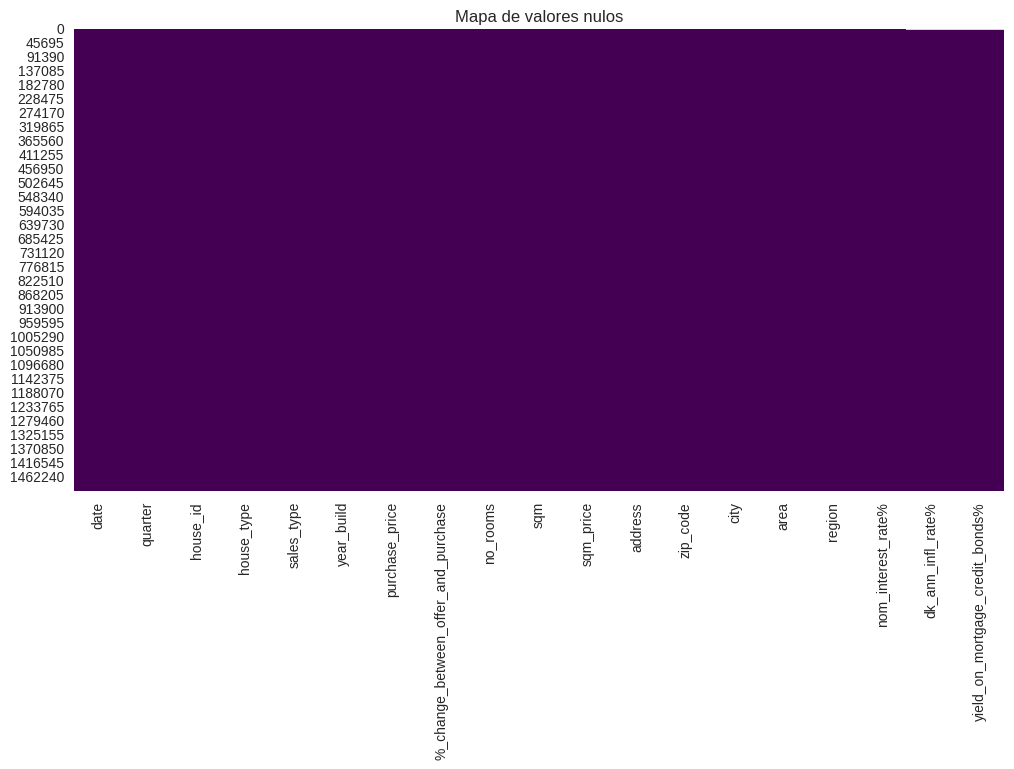

In [14]:

utils.plot_null_heatmap(df)

In [15]:
df_nulls, df_nulls_percentages = utils.get_df_null_resume_and_percentages(df)
df_nulls_percentages

column null_percentage
0  yield_on_mortgage_credit_bonds%          0.08 %
1                dk_ann_infl_rate%          0.08 %
2                             city          0.01 %
3                              sqm          0.00 %
4                        sqm_price          0.00 %

Dataframe de registros con valores vacios
(1317, 19)


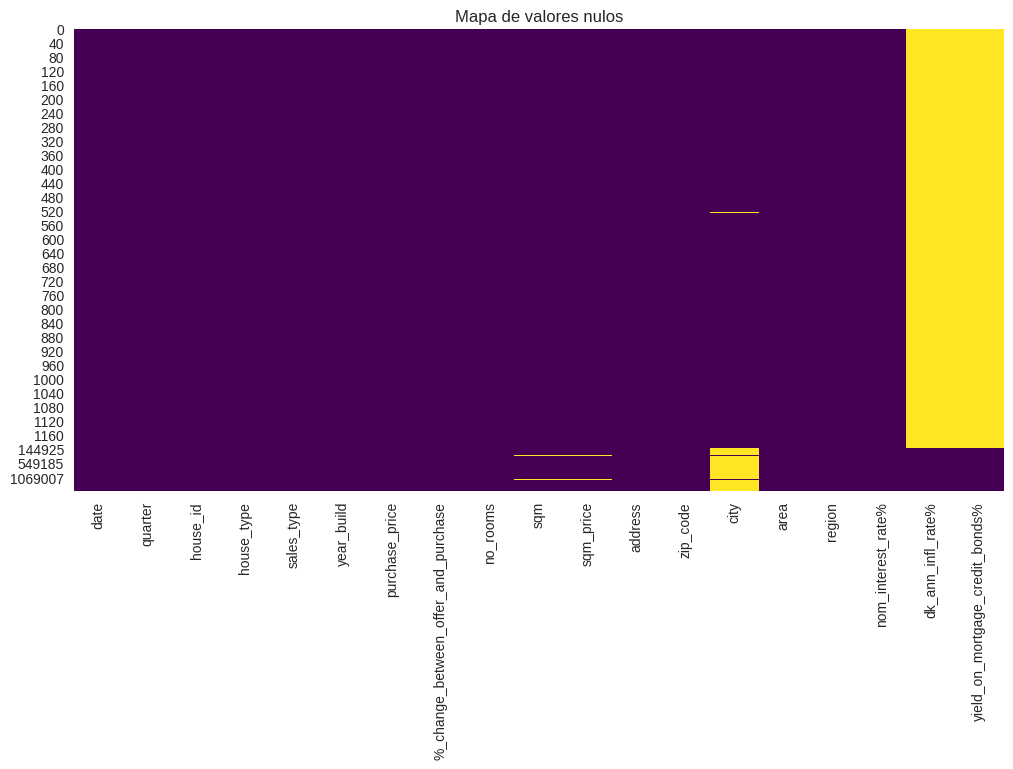

In [16]:
print("Dataframe de registros con valores vacios")
print(df_nulls.shape)
utils.plot_null_heatmap(df_nulls)

In [17]:
n = df.shape[0]
df_clean = df.dropna(subset=["sqm", "sqm_price", "dk_ann_infl_rate%", "yield_on_mortgage_credit_bonds%"])
print(f"Eliminamos {n - df.shape[0]} registros con valores vacíos, quedando {df.shape[0]} registros. Representa un {100 * (n - df.shape[0]) / n:.2f}% de los datos originales.")
df_h2o_clean = H2OFrame(df_clean)

Eliminamos 0 registros con valores vacíos, quedando 1507908 registros. Representa un 0.00% de los datos originales.
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Tratamiento de valores faltantes y duplicados

Al inspeccionar los valores nulos, se encontró que las variables `sqm`, `sqm_price`, `dk_ann_infl_rate%` y `yield_on_mortgage_credit_bonds%`, al inspeccionar visualmente no se observo su precesencia, esto es debido a que se presentan proporciones extremadamente bajas de valores faltantes — todas por debajo del 0.08%.

La literatura aplicable a machine learning recomienda que si el porcentaje de datos faltantes es `<5%`, se dichos valores se pueden eliminar sin afectar la calidad del modelo. 

Estrategia aplicada:

Siguiendo a Bello (2023) se determinó el mecanismo de perdida de datos, asimismo se caracteriza el patrón de datos perdidos. Mediante un modelo de regresion o mediante patrones de información (visualización), para clasificarlos dentro de las siguientes categorias:

- Datos perdidos al azar (MAR)                      : Asociado a otra caracteristica del sujeto
- Datos perdidos completamente al azar (MCAR)       : No relacionado a un caracteristica o respuesta del sujeto.
- Valor faltante informativo (NMAR)                 : La tencia a que falte una variable es una funcion de los datos no disponibles


De forma independiente, al tratarse de una presencia menor al 0.1 %, se decide usar el método de análsis de casos completos (eliminando los casos), sin descuidar el análsis requerido para identificar la perdida de datos.


En caso el metodo fuera modificado posteriormente, se recomienda ,salvo se determie el mecanismo de perdida de datos (MAR o NMAR), como metodo de imputación multiple:

- Para `sqm` y `sqm_price`: se impute la **mediana**, robusta frente a outliers.
- Para `dk_ann_infl_rate%` y `yield_on_mortgage_credit_bonds%`: se aplique **propagación hacia adelante** (forward fill), dada la continuidad temporal entre trimestres.



In [18]:
print("Valores duplicados por columna")
df_duplicates = df.duplicated().sum()
print(df_duplicates)

print("Duplicados por fila sin considerar 'house_id':")
df_duplicates_no_id = df[df.drop("house_id", axis=1).duplicated()]
print(df_duplicates_no_id.shape[0])  


Valores duplicados por columna
0
Duplicados por fila sin considerar 'house_id':
0


### Analisis de valores faltantes 



Dataframe de registros con valores vacios
(1317, 19)


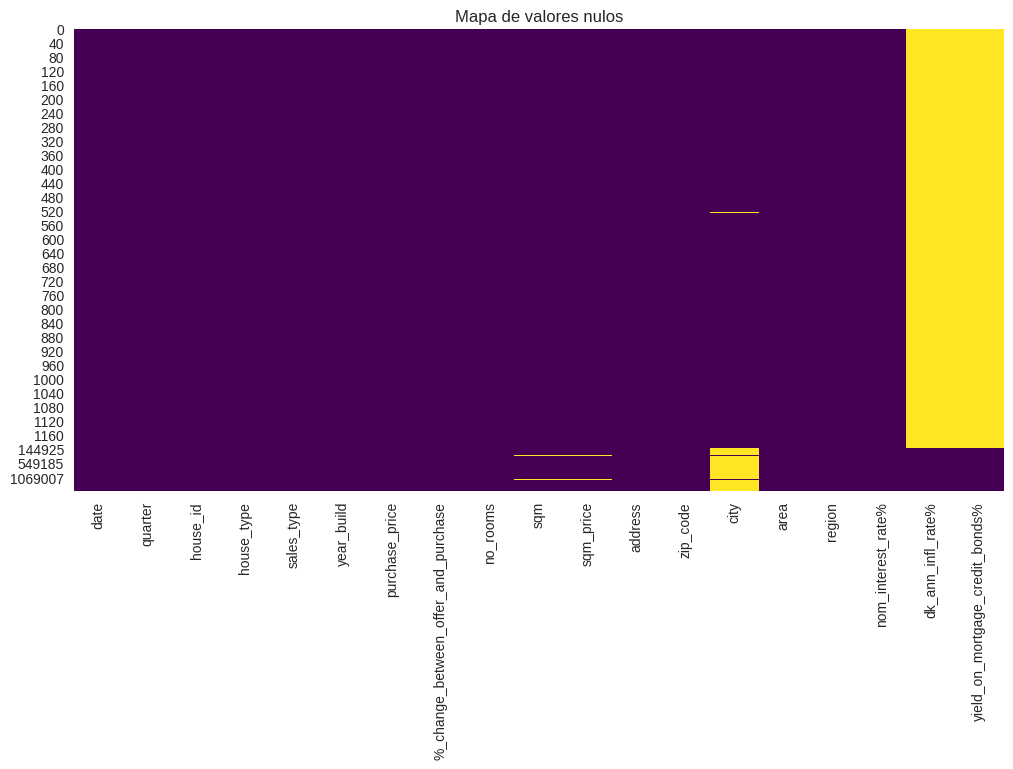

In [19]:
print("Dataframe de registros con valores vacios")
print(df_nulls.shape)
utils.plot_null_heatmap(df_nulls)

Al volver a revisar el df_null, notamos que la perdida de datos es tipo de parche y se encuentra asociado a los primero registros,

In [20]:
df_null_yield = df_nulls[df_nulls["yield_on_mortgage_credit_bonds%"].isnull()]

In [21]:
df[df["quarter"]== 219]

date  quarter  house_id   house_type    sales_type  \
0     1729900800000000000      219         0        Villa  regular_sale   
1     1729900800000000000      219         2  Summerhouse  regular_sale   
2     1729900800000000000      219         1         Farm  regular_sale   
3     1729814400000000000      219         3    Apartment   family_sale   
4     1729814400000000000      219         4        Villa  regular_sale   
...                   ...      ...       ...          ...           ...   
1188  1727740800000000000      219      1109        Villa  regular_sale   
1189  1727740800000000000      219      1110         Farm  regular_sale   
1190  1727740800000000000      219      1111        Villa  regular_sale   
1191  1727740800000000000      219      1112    Townhouse  regular_sale   
1192  1727740800000000000      219      1113  Summerhouse  regular_sale   

      year_build  purchase_price  %_change_between_offer_and_purchase  \
0           1974         4350000                                    0   
1           1956          450000                                    0   
2           1955         6600000                                    0   
3           1945         1495000                                    0   
4           1967         3375000                                    0   
...          ...             ...                                  ...   
1188        1925          775000                                   -3   
1189        1898          375000                                    0   
1190        1974         3600000                                   -1   
1191        1969          625000                                  -10   
1192        1965         1750000                                    0   

      no_rooms    sqm     sqm_price                     address  zip_code  \
0            5  215.0  20232.558594               Kildevangen 5      8382   
1            3   36.0  12500.000000                Lykkestien 2      4400   
2            3  180.0  36666.667969               Sæderupvej 58      9260   
3            2   64.0  23359.375000  Tage-Hansens Gade 5, 1. tv      8000   
4            5  176.0  19176.136719          Chr.Winthers Vej 5      8600   
...        ...    ...           ...                         ...       ...   
1188         3  168.0   4613.095215                Mosevænget 5      6560   
1189         9  208.0   1802.884644                    Næsvej 4      4850   
1190         4  114.0  31578.947266               Lykkesholm 37      2690   
1191         4  104.0   6009.615234       Herluf Trolles Vej 43      9900   
1192         4   99.0  17676.767578                 Kragevej 18      9850   

               city                 area   region  nom_interest_rate%  \
0          Hinnerup   East & mid jutland  Jutland                 3.1   
1        Kalundborg        Other islands  Zealand                 3.1   
2           Gistrup        North jutland  Jutland                 3.1   
3          Aarhus C   East & mid jutland  Jutland                 3.1   
4         Silkeborg   East & mid jutland  Jutland                 3.1   
...             ...                  ...      ...                 ...   
1188     Sommersted        South jutland  Jutland                 3.1   
1189   Stubbekøbing        Other islands  Zealand                 3.1   
1190     Karlslunde  Capital, Copenhagen  Zealand                 3.1   
1191  Frederikshavn        North jutland  Jutland                 3.1   
1192      Hirtshals        North jutland  Jutland                 3.1   

     dk_ann_infl_rate% yield_on_mortgage_credit_bonds%  
0                 None                            None  
1                 None                            None  
2                 None                            None  
3                 None                            None  
4                 None                            None  
...                ...                             ...  
1188              None                    

1. Verificamos que todos los de `df_null_yield` están `df` con `quarter = 219`
2. Verificamos que `df_null_yield` tiene la misma cantidad que `df` con `quarter = 219`
3. Verificamos que son los mismos índices


In [22]:
assert all(df_null_yield["quarter"] == 219), "No todos los registros de df_null_yield están en df con quarter 219"

assert df[df["quarter"] == 219].shape[0] == df_null_yield.shape[0]

assert set(df[df["quarter"] == 219].index) == set(df_null_yield.index), "Los índices de df_null_yield y df con quarter 219 no coinciden"


No se encontraron registros duplicados, consecuentemente no se tomaron medidas en este aspecto.

### Analisis Univariado

In [23]:
categorical_columns, numeric_columns

(['house_type', 'sales_type', 'address', 'city', 'area', 'region'],
 ['date',
  'quarter',
  'house_id',
  'year_build',
  'purchase_price',
  '%_change_between_offer_and_purchase',
  'no_rooms',
  'sqm',
  'sqm_price',
  'zip_code',
  'nom_interest_rate%',
  'dk_ann_infl_rate%',
  'yield_on_mortgage_credit_bonds%'])

In [24]:
# Check available columns in df_clean
print("Columns in df_clean:")
print(df_clean.columns.tolist())

Columns in df_clean:
['date', 'quarter', 'house_id', 'house_type', 'sales_type', 'year_build', 'purchase_price', '%_change_between_offer_and_purchase', 'no_rooms', 'sqm', 'sqm_price', 'address', 'zip_code', 'city', 'area', 'region', 'nom_interest_rate%', 'dk_ann_infl_rate%', 'yield_on_mortgage_credit_bonds%']



Análisis de `sqm`:
  - min: 26.00
  - max: 997.00
  - mean: 129.26
  - median: 123.00
  - std: 57.20
  - skew: 1.79
  - normal_stat: 674,913.28
  - normal_p: 0.00
  - is_normal: False


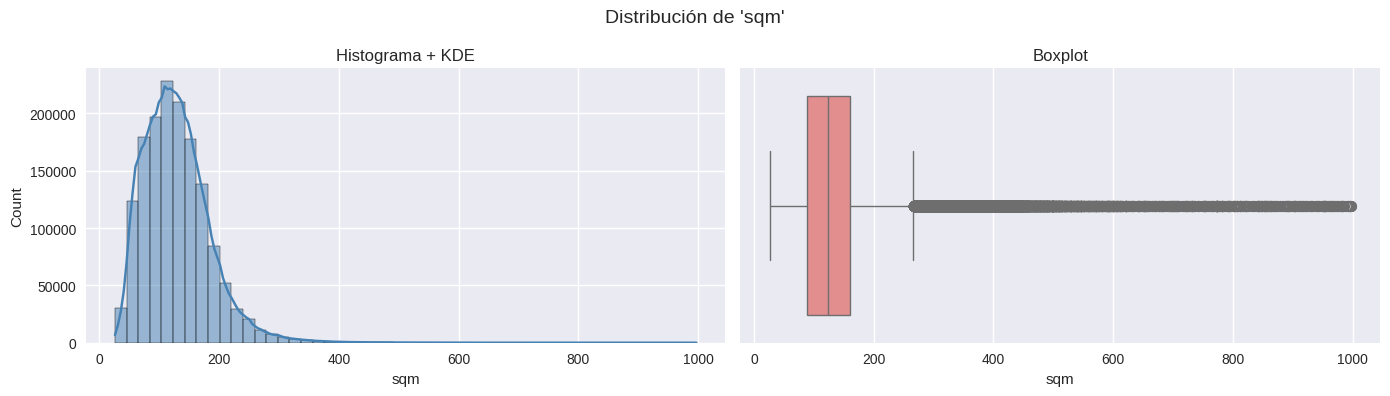

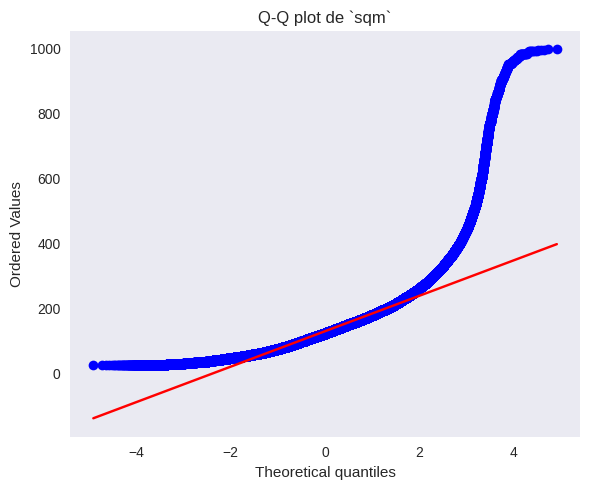


Análisis de `sqm_price`:
  - min: 269.86
  - max: 75,000.00
  - mean: 16,341.58
  - median: 12,000.00
  - std: 13,623.47
  - skew: 1.68
  - normal_stat: 461,383.99
  - normal_p: 0.00
  - is_normal: False


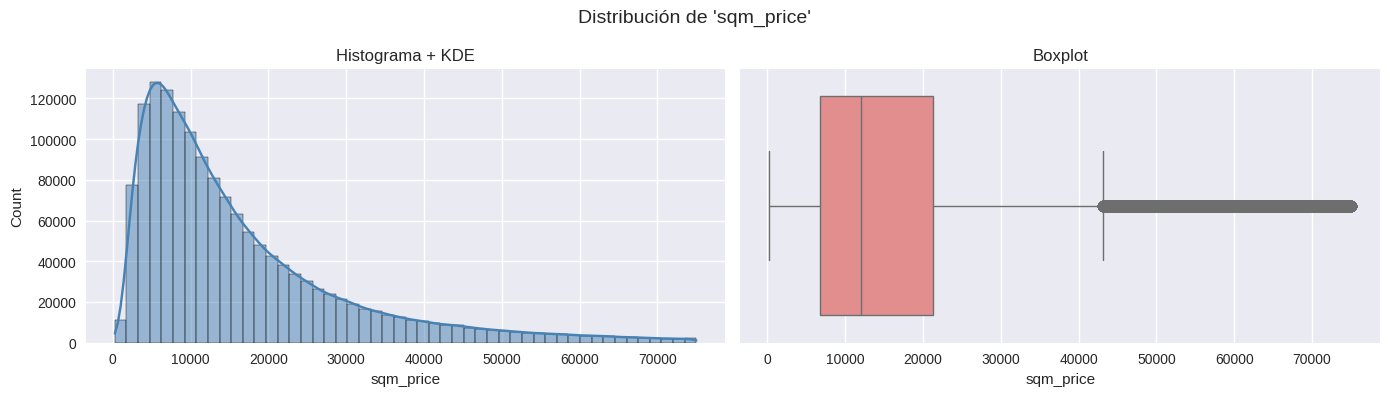

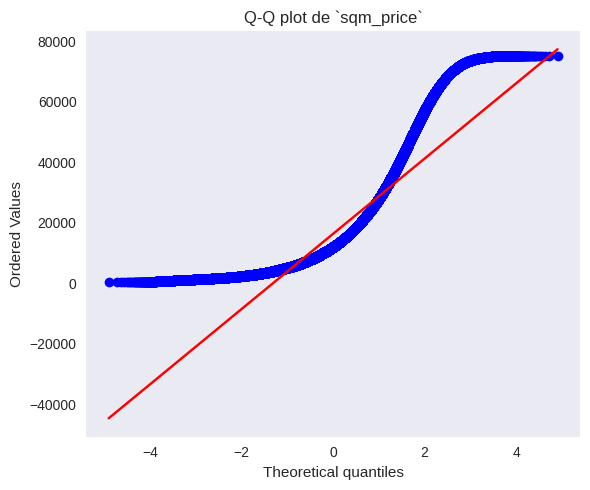


Análisis de `nom_interest_rate%`:
  - min: 0.00
  - max: 9.50
  - mean: 1.68
  - median: 0.75
  - std: 2.04
  - skew: 1.34
  - normal_stat: 346,227.26
  - normal_p: 0.00
  - is_normal: False


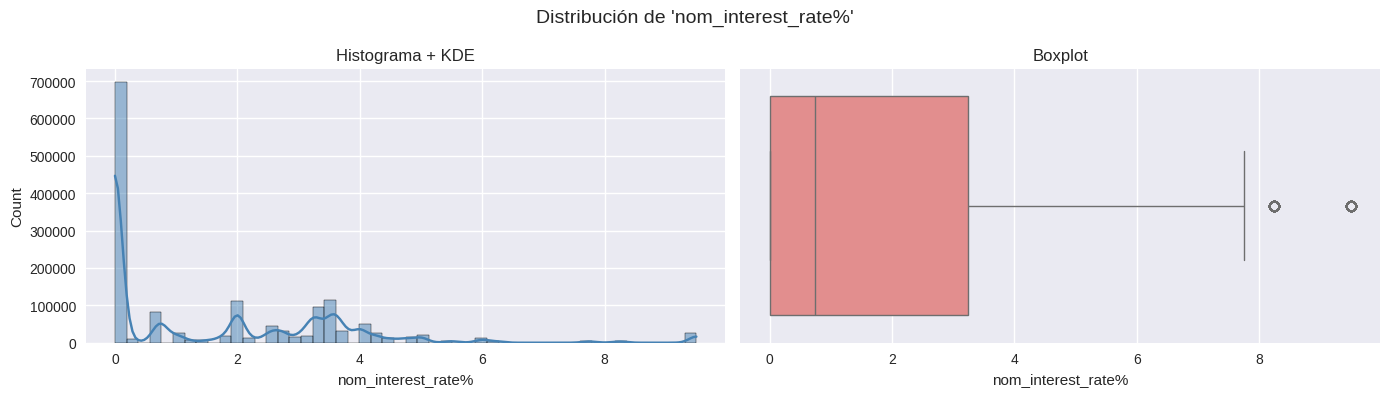

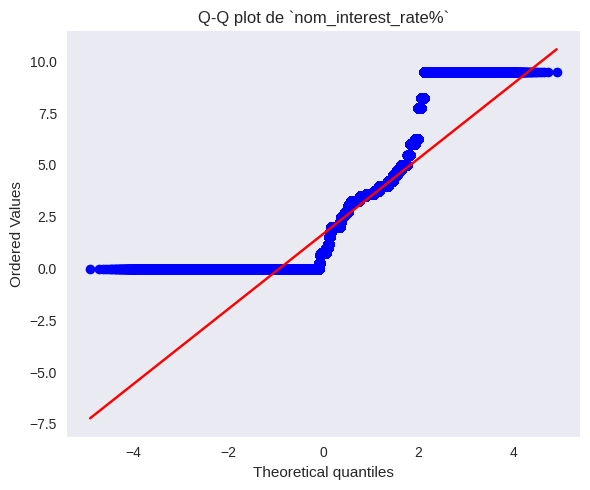


--- Análisis de 'house_type' ---


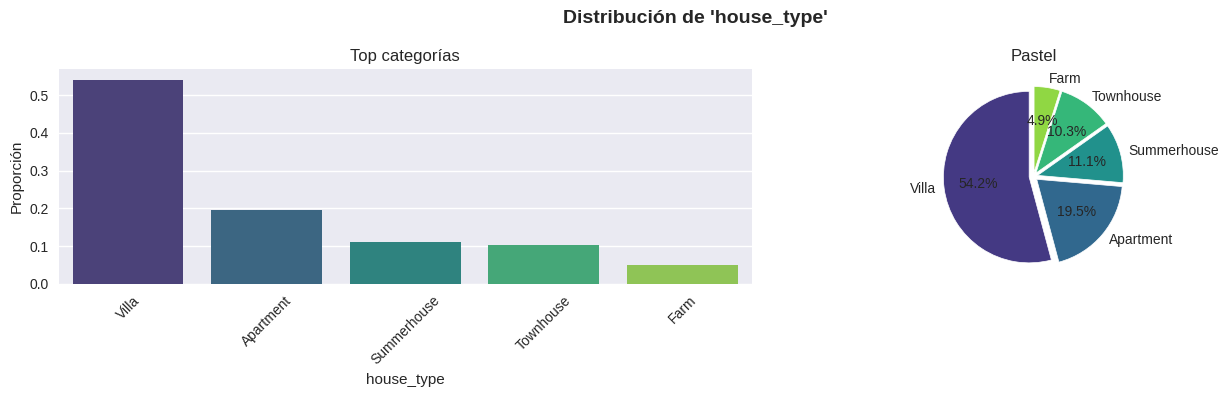

- Valores únicos (originales): 5
- Distribución mostrada:
house_type
Villa          0.5417
Apartment      0.1948
Summerhouse    0.1114
Townhouse      0.1031
Farm           0.0491
Name: proportion, dtype: float64

--- Análisis de 'sales_type' ---


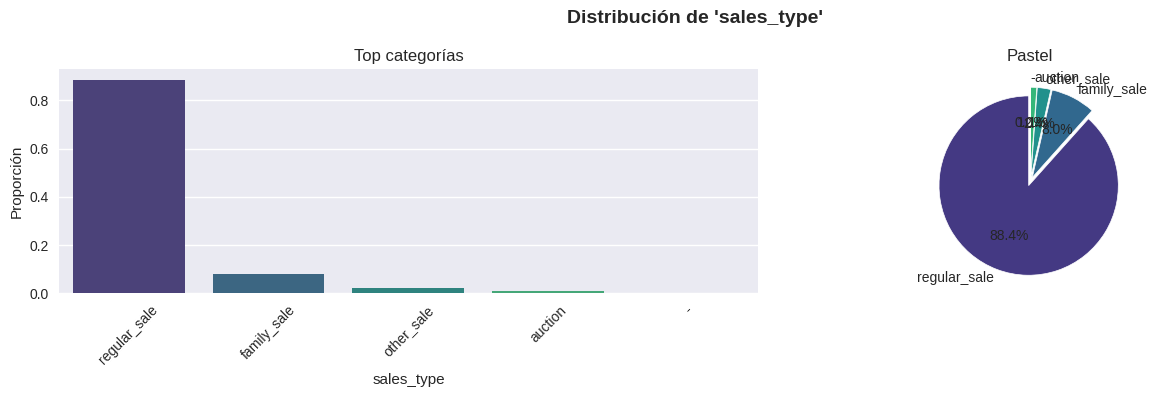

- Valores únicos (originales): 5
- Distribución mostrada:
sales_type
regular_sale    0.8839
family_sale     0.0804
other_sale      0.0243
auction         0.0114
-               0.0000
Name: proportion, dtype: float64

--- Análisis de 'address' ---

--- WordCloud para 'address' ---


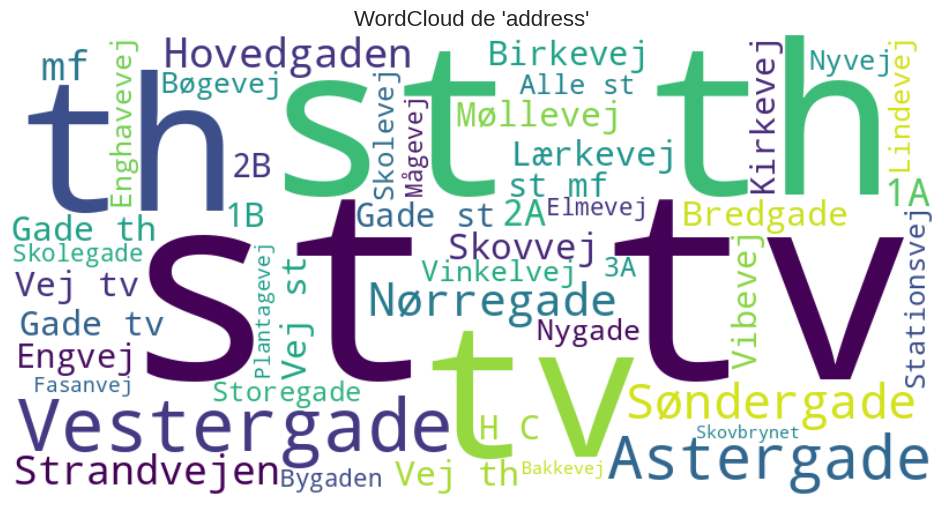


--- Análisis de 'city' ---

--- WordCloud para 'city' ---


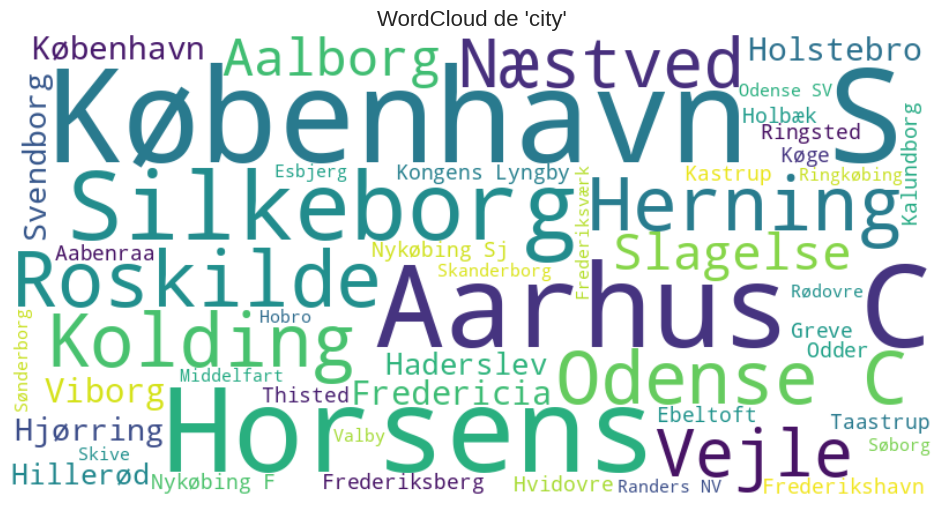


--- Análisis de 'area' ---


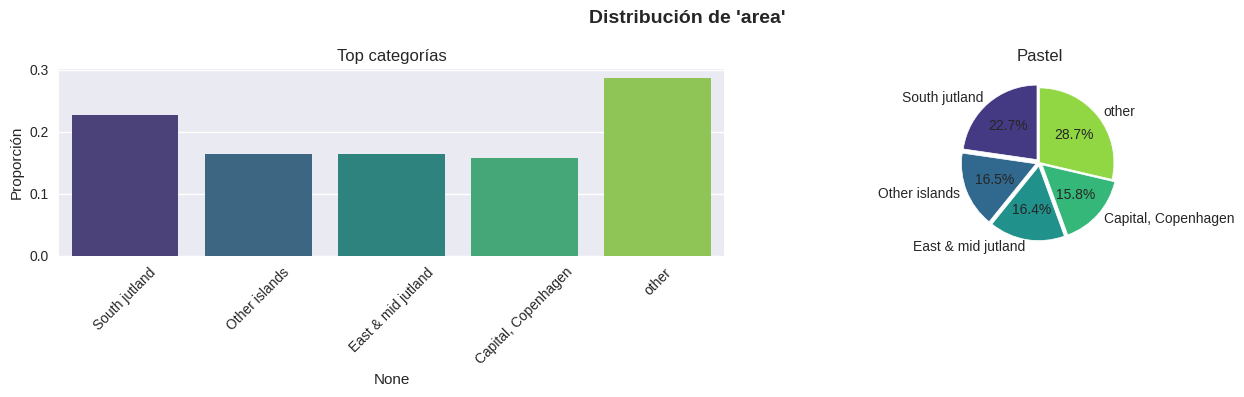

- Valores únicos (originales): 8
- Distribución mostrada:
South jutland          0.2271
Other islands          0.1646
East & mid jutland     0.1639
Capital, Copenhagen    0.1578
other                  0.2865
dtype: float64

--- Análisis de 'region' ---


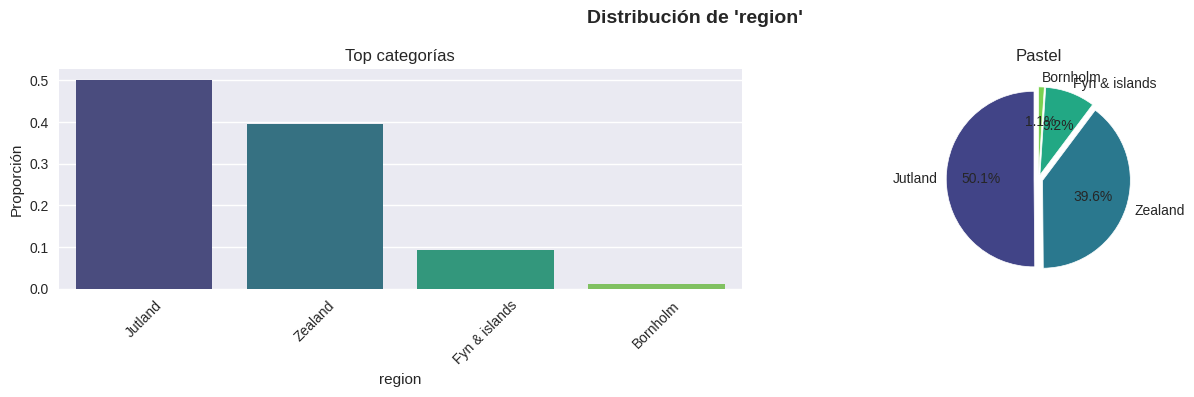

- Valores únicos (originales): 4
- Distribución mostrada:
region
Jutland          0.5013
Zealand          0.3963
Fyn & islands    0.0919
Bornholm         0.0105
Name: proportion, dtype: float64


In [25]:
key_columns_continuous = ["purchase_price", "sqm", "sqm_price", "date", "year_build"]
key_columns_discrete = ["quarter", "house_type",  "area", "no_rooms"]




utils.run_univariate_analysis(
    df=df_clean,
    continuous_cols= df_clean.select_dtypes(include=["float64"]).columns.tolist(),
    discrete_cols= df_clean.select_dtypes(include=["int32"]).columns.tolist(),
    categorical_cols= categorical_columns
)




#utils.plot_univariate_analysis(df_clean, key_columns_continuous, key_columns_discrete)


ANÁLISIS UNIVARIADO MEJORADO: PURCHASE_PRICE

ESTADÍSTICAS DESCRIPTIVAS:
   • Observaciones: 1,506,713
   • Valores únicos: 126,939
   • Valores nulos: 0 (0.00%)
   • Mínimo: 250,010.00
   • Q1 (25%): 800,000.00
   • Mediana: 1,400,000.00
   • Q3 (75%): 2,450,000.00
   • Máximo: 46,800,000.00
   • Media: 1,915,212.93
   • Desviación estándar: 1,765,414.32

MEDIDAS DE FORMA:
   • Asimetría (Skewness): 3.447
     → Interpretación: Asimetría positiva (cola derecha)
   • Curtosis: 25.999
     → Interpretación: Leptocúrtica (más puntiaguda que normal)
   • Coeficiente de variación: 92.18%
     → Interpretación: Alta variabilidad

DETECCIÓN DE OUTLIERS (Método IQR):
   • Límite inferior: -1675000.00
   • Límite superior: 4925000.00
   • Total de outliers: 82,688 (5.49%)
   • Outliers más extremos:
     → 46,800,000.00
     → 46,000,000.00
     → 4,925,286.00
     → 4,925,362.00
     → 4,925,300.00

TESTS DE NORMALIDAD:
   • Jarque-Bera Test:
     → Estadístico: 45421048.095
     → p-valor: 

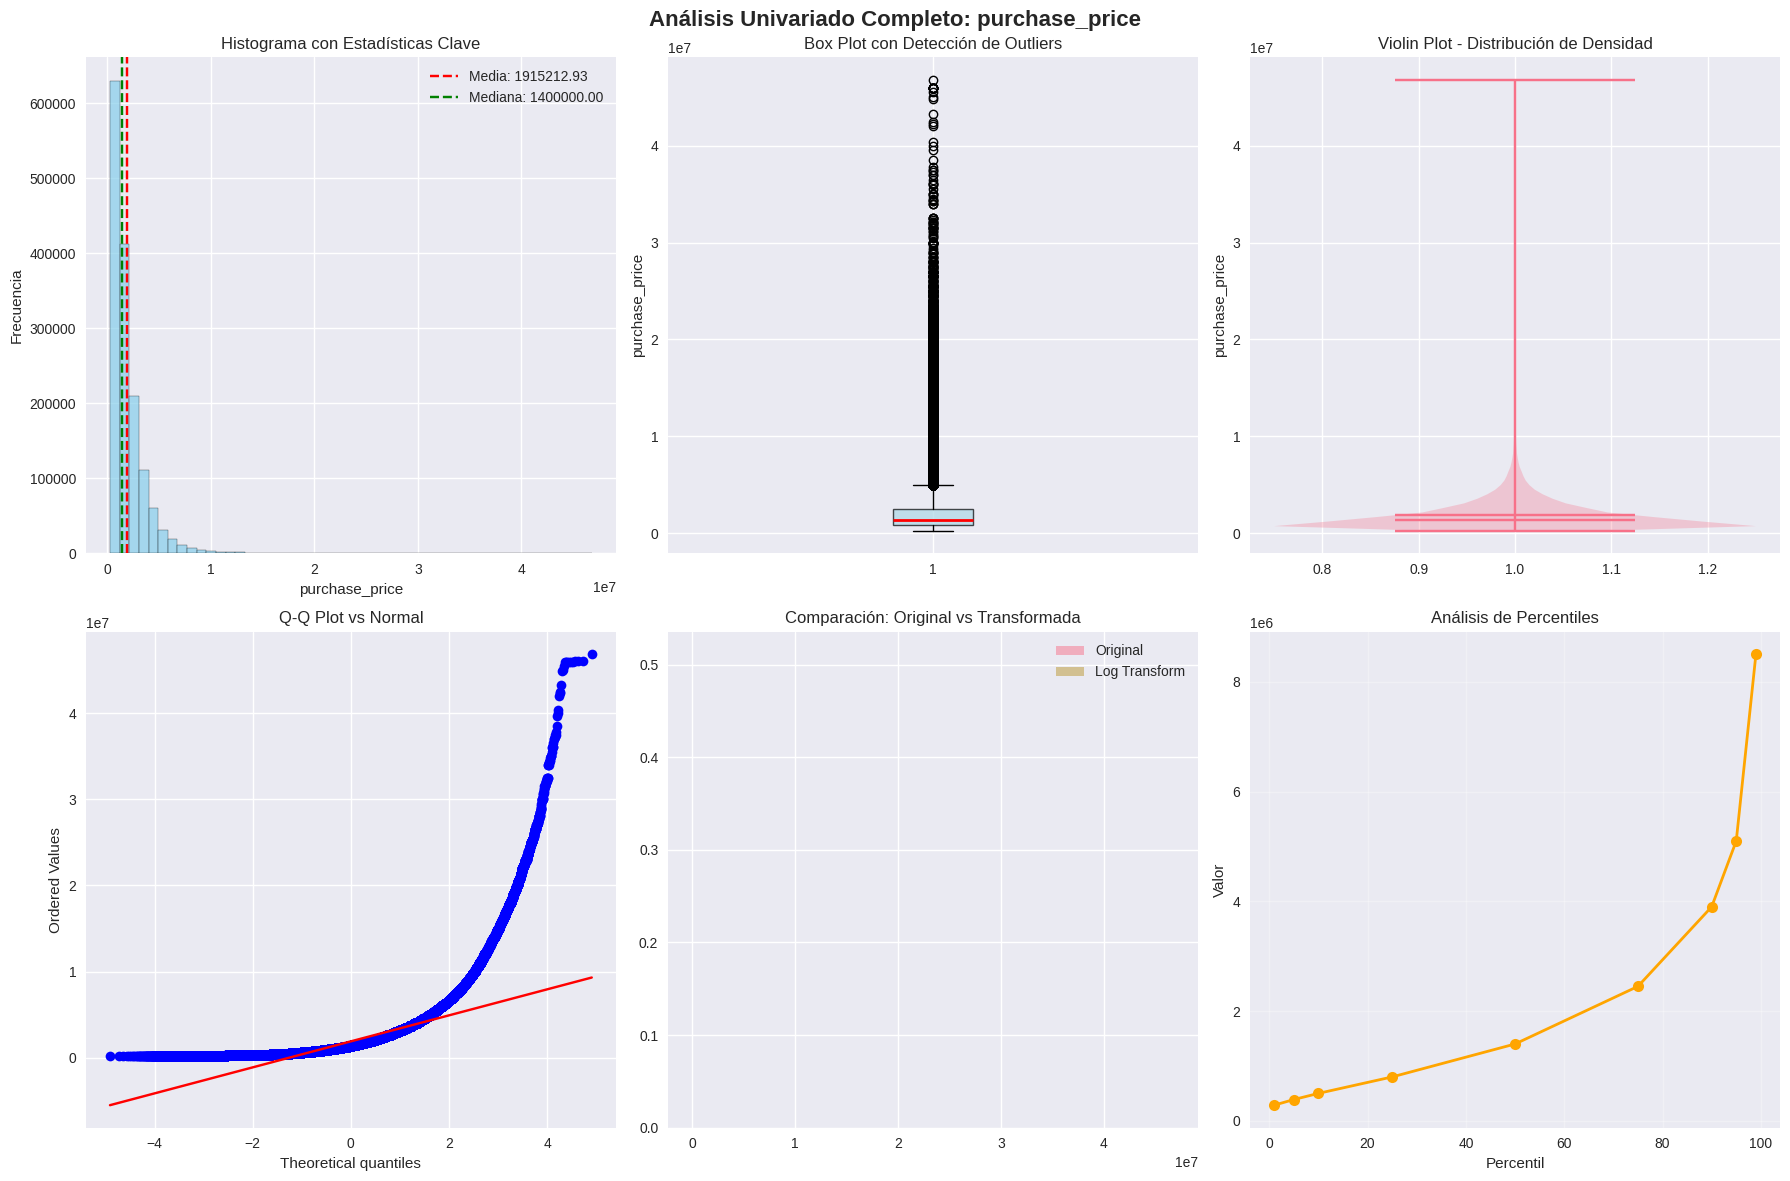


INSIGHTS DE NEGOCIO:
   • Concentración de datos: 0.07
     → El 80% de los datos se concentra en 7.3% del rango total
   • Alta variabilidad sugiere potencial para segmentación

RECOMENDACIONES DE PREPROCESSING:
   • Considerar tratamiento de outliers (winsorizing, capping)
   • Considerar transformación para reducir asimetría:
     → Transformación logarítmica, Box-Cox, o raíz cuadrada


In [26]:
# Análisis detallado de purchase_price - Variable objetivo principal
purchase_price_analysis = utils.enhanced_univariate_analysis(df_clean, 'purchase_price', 'numeric')


ANÁLISIS UNIVARIADO MEJORADO: SQM_PRICE

ESTADÍSTICAS DESCRIPTIVAS:
   • Observaciones: 1,506,713
   • Valores únicos: 320,635
   • Valores nulos: 0 (0.00%)
   • Mínimo: 269.86
   • Q1 (25%): 6,740.15
   • Mediana: 12,000.00
   • Q3 (75%): 21,311.47
   • Máximo: 75,000.00
   • Media: 16,341.58
   • Desviación estándar: 13,623.47

MEDIDAS DE FORMA:
   • Asimetría (Skewness): 1.676
     → Interpretación: Asimetría positiva (cola derecha)
   • Curtosis: 2.858
     → Interpretación: Leptocúrtica (más puntiaguda que normal)
   • Coeficiente de variación: 83.37%
     → Interpretación: Alta variabilidad

DETECCIÓN DE OUTLIERS (Método IQR):
   • Límite inferior: -15116.84
   • Límite superior: 43168.47
   • Total de outliers: 91,037 (6.04%)
   • Outliers más extremos:
     → 75,000.00
     → 43,169.02
     → 43,169.40
     → 43,168.61

TESTS DE NORMALIDAD:
   • Jarque-Bera Test:
     → Estadístico: 1217927.232
     → p-valor: 0.000000
     → Resultado: No normal


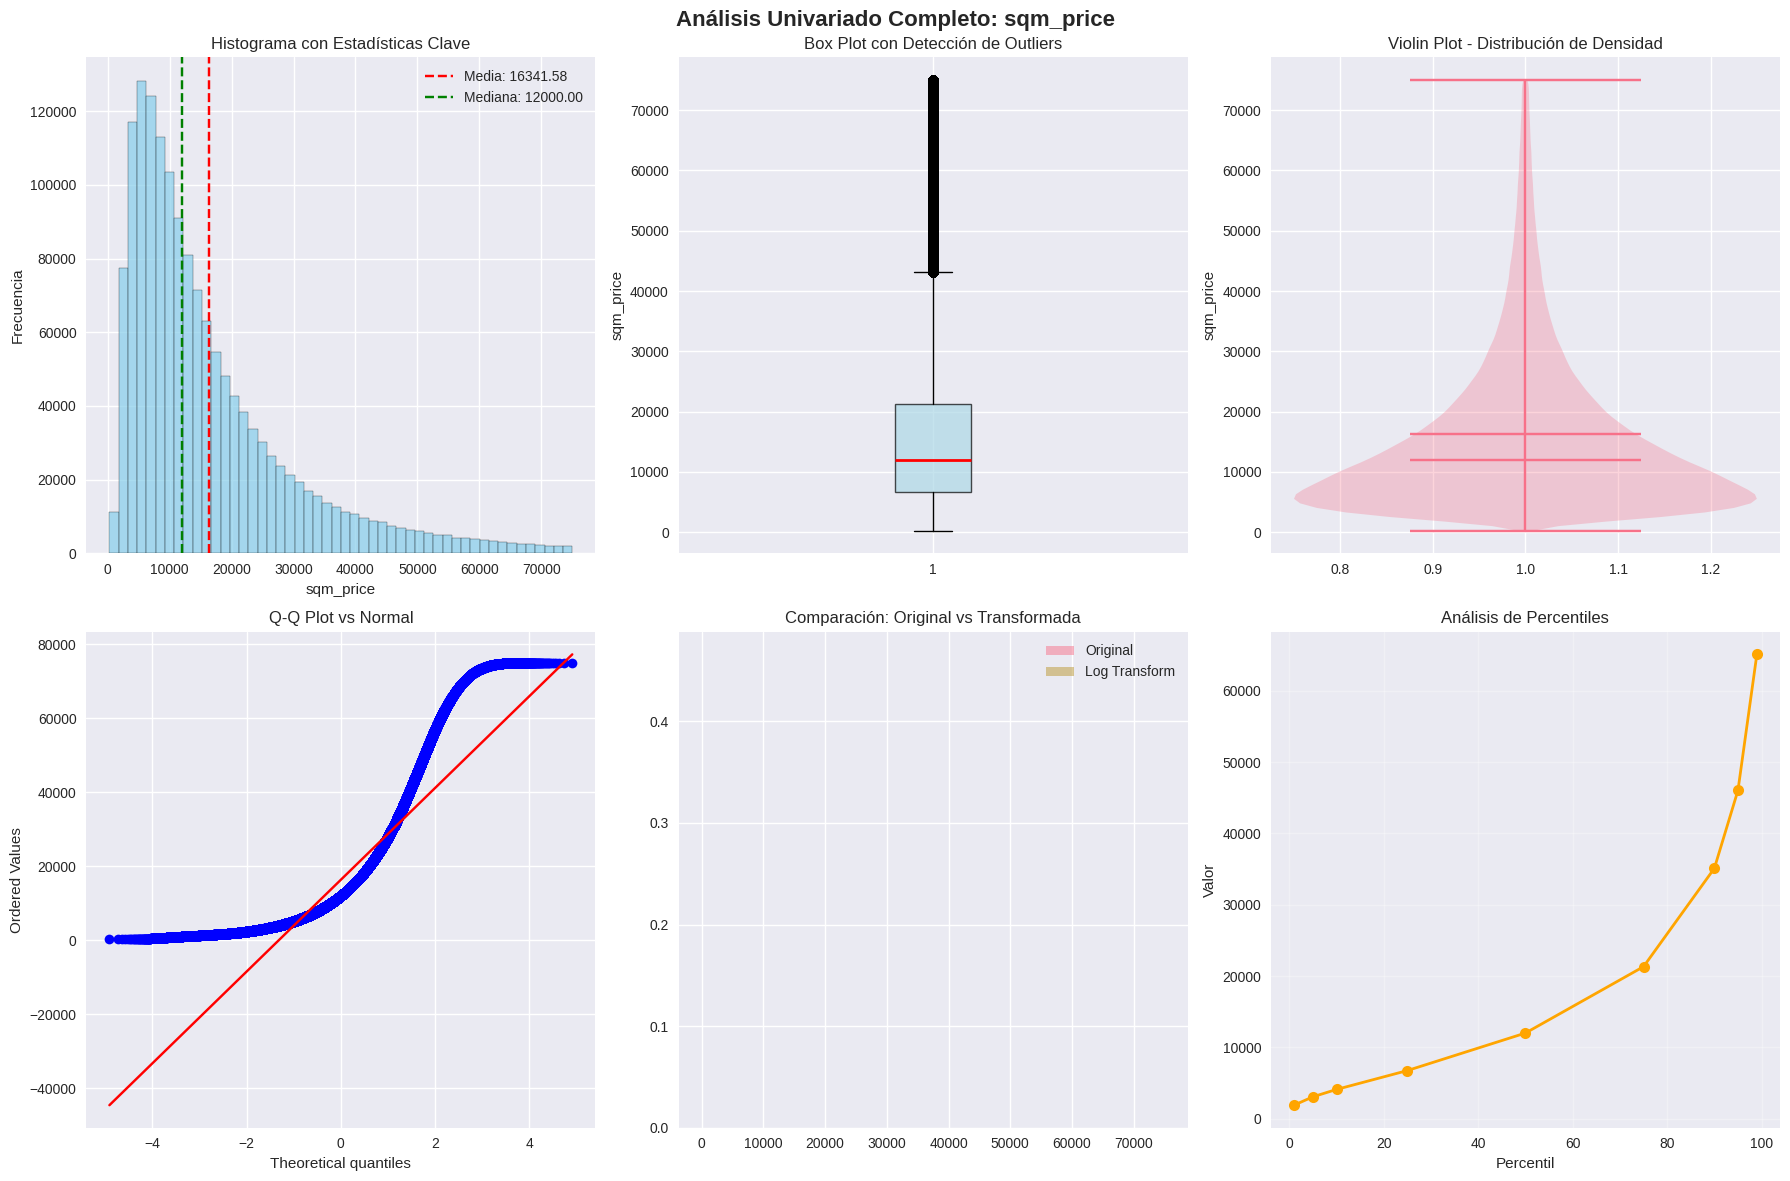


INSIGHTS DE NEGOCIO:
   • Concentración de datos: 0.42
     → El 80% de los datos se concentra en 41.5% del rango total
   • Alta variabilidad sugiere potencial para segmentación

RECOMENDACIONES DE PREPROCESSING:
   • Considerar tratamiento de outliers (winsorizing, capping)
   • Considerar transformación para reducir asimetría:
     → Transformación logarítmica, Box-Cox, o raíz cuadrada


In [27]:
# Análisis detallado de sqm_price - Precio por metro cuadrado
sqm_price_analysis = utils.enhanced_univariate_analysis(df_clean, 'sqm_price', 'numeric')

### Características Físicas de las Propiedades


ANÁLISIS UNIVARIADO MEJORADO: SQM

ESTADÍSTICAS DESCRIPTIVAS:
   • Observaciones: 1,506,713
   • Valores únicos: 865
   • Valores nulos: 0 (0.00%)
   • Mínimo: 26.00
   • Q1 (25%): 89.00
   • Mediana: 123.00
   • Q3 (75%): 160.00
   • Máximo: 997.00
   • Media: 129.26
   • Desviación estándar: 57.20

MEDIDAS DE FORMA:
   • Asimetría (Skewness): 1.785
     → Interpretación: Asimetría positiva (cola derecha)
   • Curtosis: 11.808
     → Interpretación: Leptocúrtica (más puntiaguda que normal)
   • Coeficiente de variación: 44.25%
     → Interpretación: Alta variabilidad



DETECCIÓN DE OUTLIERS (Método IQR):
   • Límite inferior: -17.50
   • Límite superior: 266.50
   • Total de outliers: 30,899 (2.05%)
   • Outliers más extremos:
     → 267.00
     → 996.00
     → 997.00

TESTS DE NORMALIDAD:
   • Jarque-Bera Test:
     → Estadístico: 9554119.273
     → p-valor: 0.000000
     → Resultado: No normal


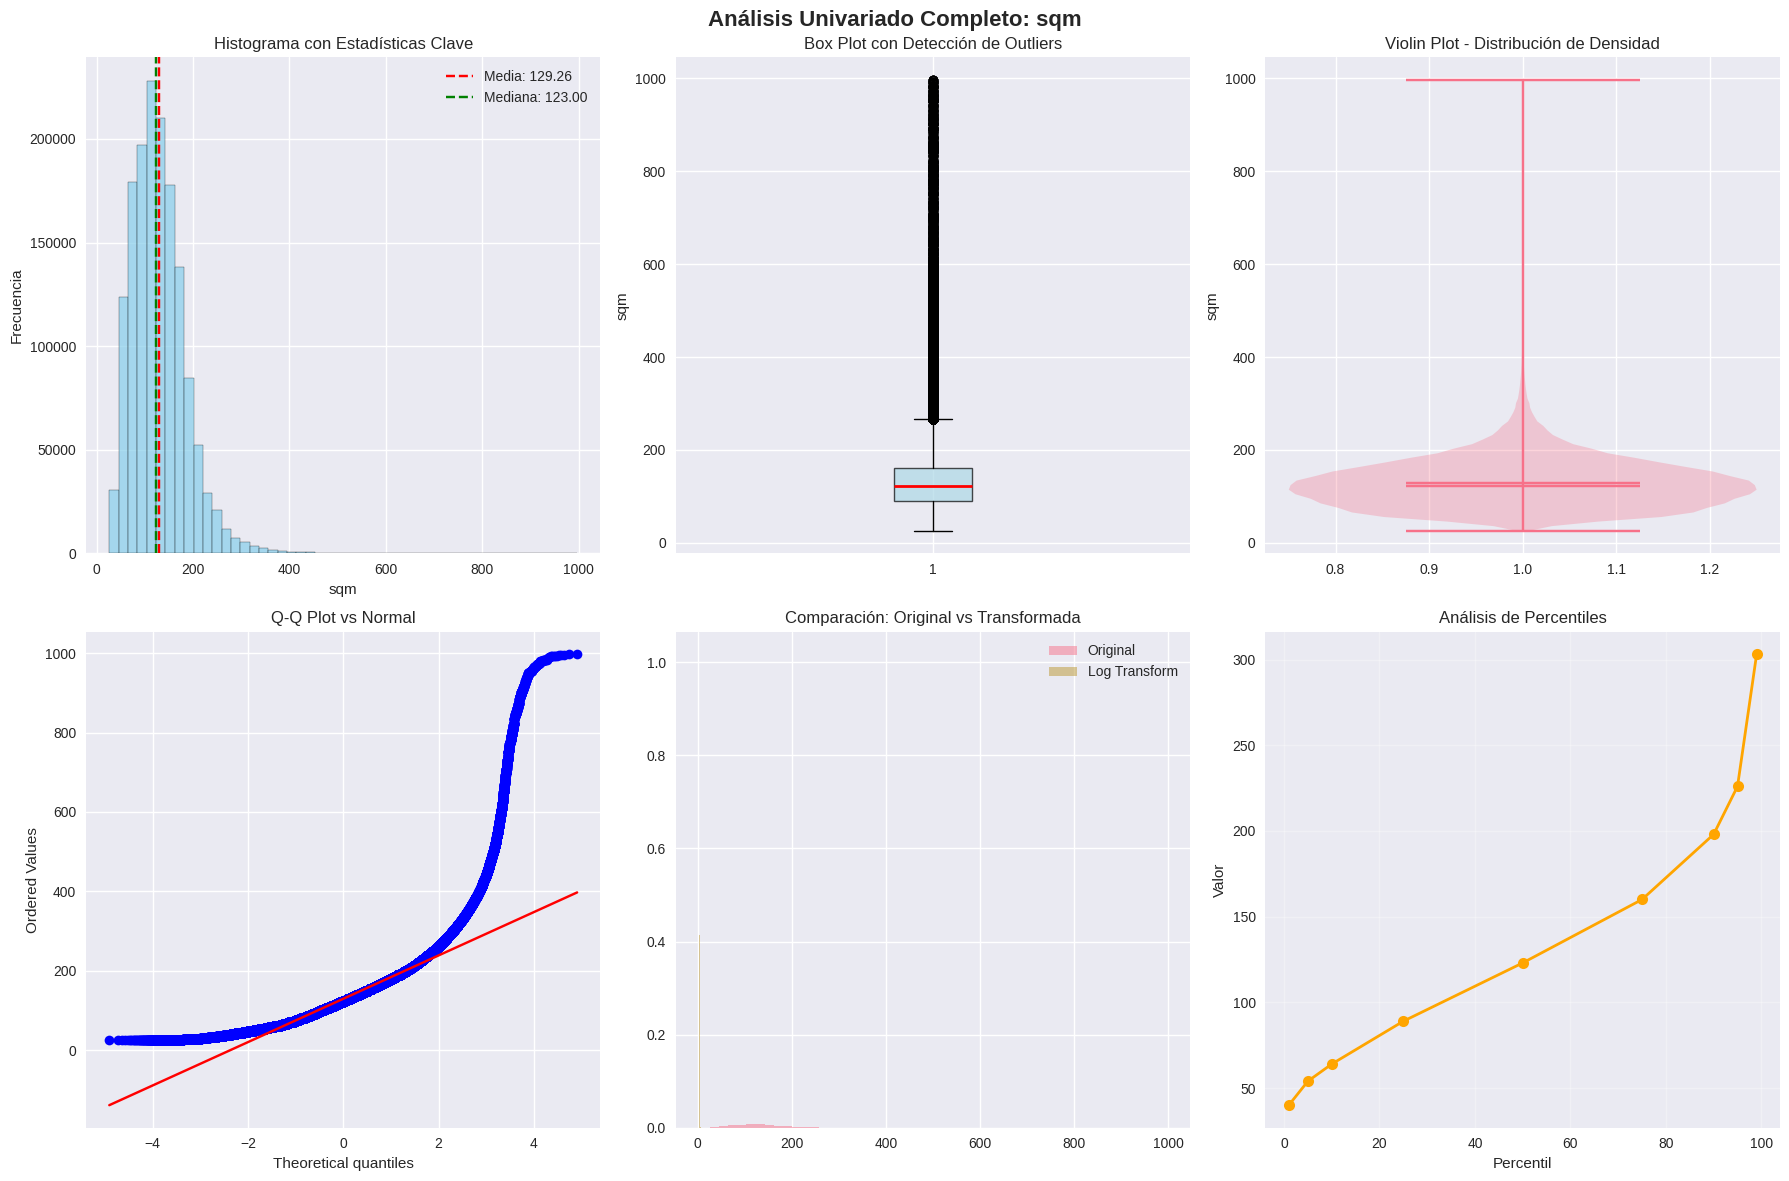


INSIGHTS DE NEGOCIO:
   • Concentración de datos: 0.14
     → El 80% de los datos se concentra en 13.8% del rango total

RECOMENDACIONES DE PREPROCESSING:
   • Considerar transformación para reducir asimetría:
     → Transformación logarítmica, Box-Cox, o raíz cuadrada


In [28]:
# Análisis detallado de sqm - Metros cuadrados
sqm_analysis = utils.enhanced_univariate_analysis(df_clean, 'sqm', 'numeric')


ANÁLISIS UNIVARIADO MEJORADO: NO_ROOMS

ESTADÍSTICAS DESCRIPTIVAS:
   • Observaciones: 1,506,713
   • Valores únicos: 15
   • Valores nulos: 0 (0.00%)
   • Mínimo: 1.00
   • Q1 (25%): 3.00
   • Mediana: 4.00
   • Q3 (75%): 5.00
   • Máximo: 15.00
   • Media: 4.37
   • Desviación estándar: 1.65

MEDIDAS DE FORMA:
   • Asimetría (Skewness): 0.866
     → Interpretación: Asimetría positiva (cola derecha)
   • Curtosis: 2.026
     → Interpretación: Leptocúrtica (más puntiaguda que normal)
   • Coeficiente de variación: 37.75%
     → Interpretación: Alta variabilidad

DETECCIÓN DE OUTLIERS (Método IQR):
   • Límite inferior: 0.00
   • Límite superior: 8.00
   • Total de outliers: 26,919 (1.79%)
   • Outliers más extremos:
     → 9.00
     → 15.00

TESTS DE NORMALIDAD:


   • Jarque-Bera Test:
     → Estadístico: 445987.320
     → p-valor: 0.000000
     → Resultado: No normal


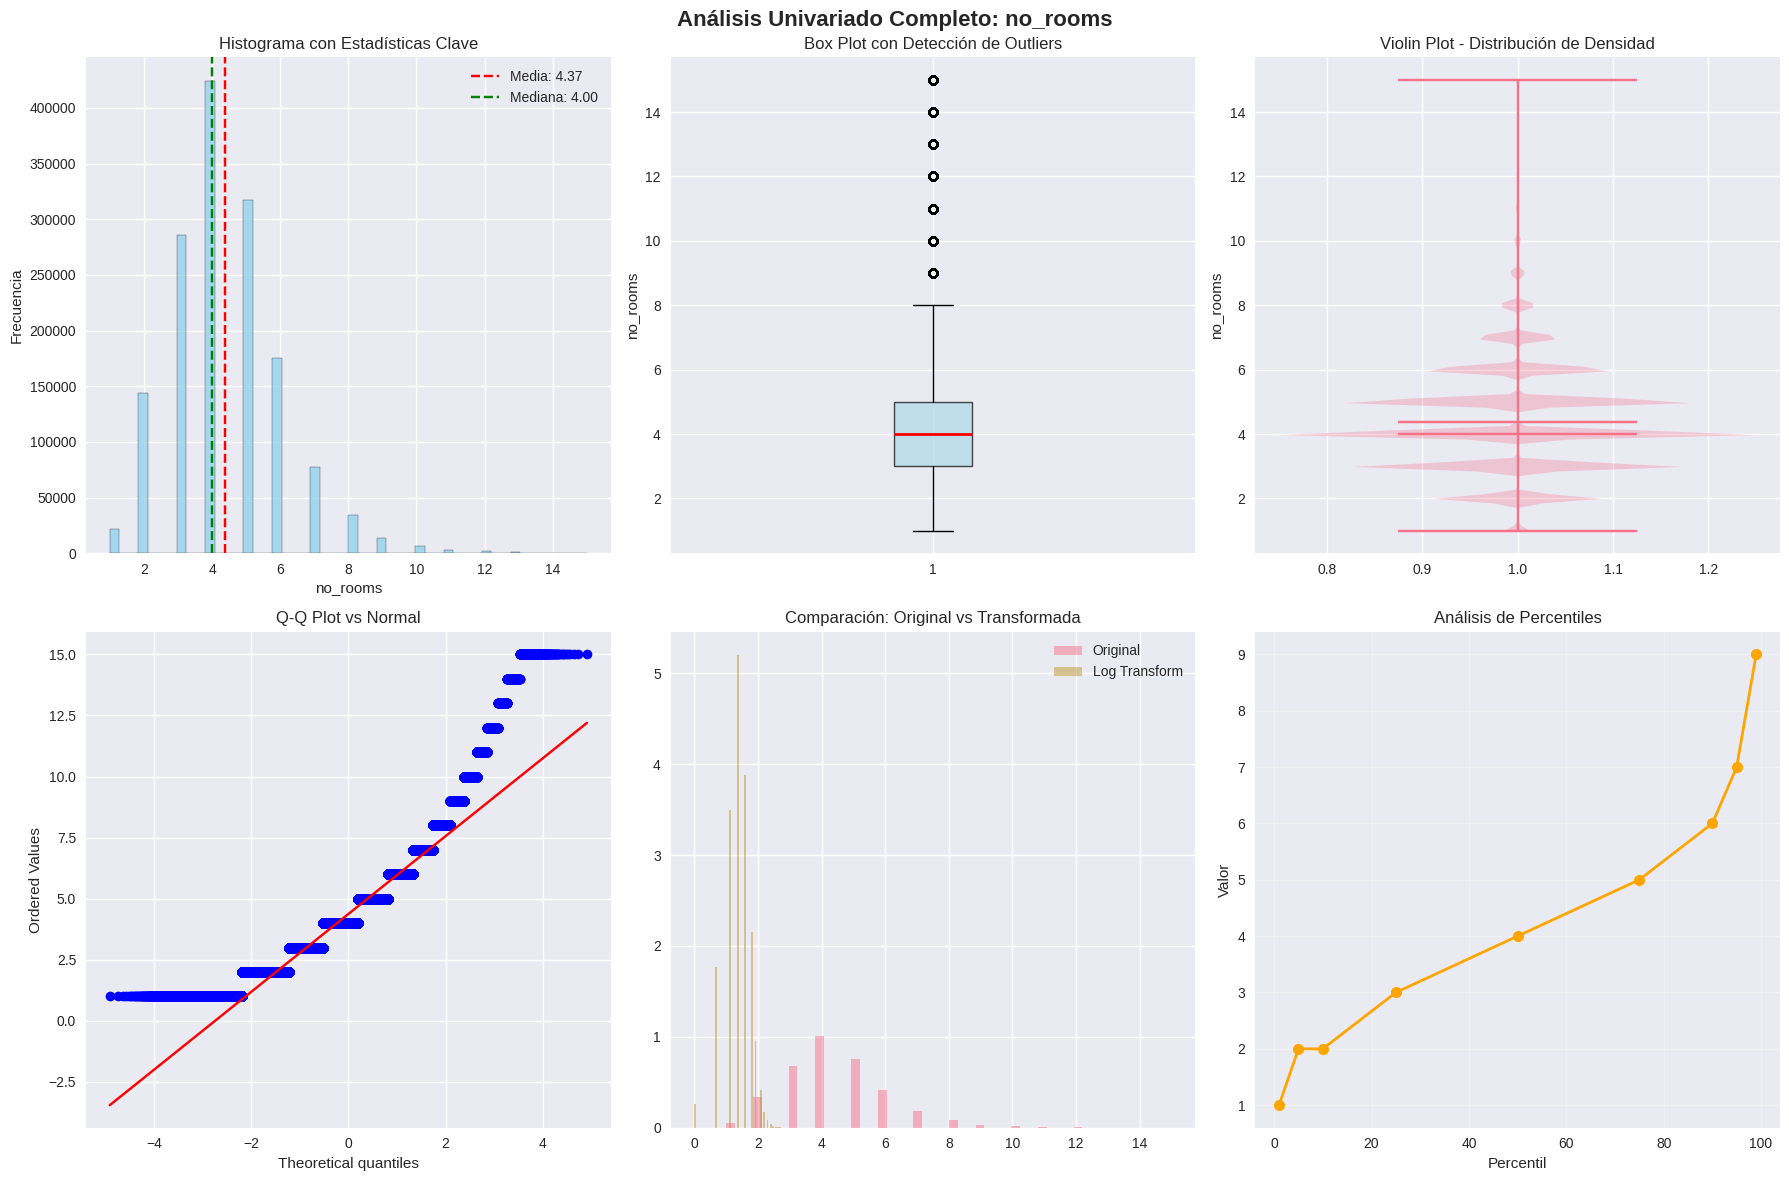


INSIGHTS DE NEGOCIO:
   • Concentración de datos: 0.29
     → El 80% de los datos se concentra en 28.6% del rango total

RECOMENDACIONES DE PREPROCESSING:


In [29]:
# Análisis detallado de no_rooms - Número de habitaciones
no_rooms_analysis = utils.enhanced_univariate_analysis(df_clean, 'no_rooms', 'numeric')

### Variables Temporales y Económicas


ANÁLISIS UNIVARIADO MEJORADO: YEAR_BUILD

ESTADÍSTICAS DESCRIPTIVAS:
   • Observaciones: 1,506,713
   • Valores únicos: 458
   • Valores nulos: 0 (0.00%)
   • Mínimo: 1,000.00
   • Q1 (25%): 1,931.00
   • Mediana: 1,965.00
   • Q3 (75%): 1,980.00
   • Máximo: 2,024.00
   • Media: 1,954.94
   • Desviación estándar: 45.84

MEDIDAS DE FORMA:
   • Asimetría (Skewness): -2.715
     → Interpretación: Asimetría negativa (cola izquierda)
   • Curtosis: 34.863
     → Interpretación: Leptocúrtica (más puntiaguda que normal)
   • Coeficiente de variación: 2.35%
     → Interpretación: Baja variabilidad

DETECCIÓN DE OUTLIERS (Método IQR):
   • Límite inferior: 1857.50
   • Límite superior: 2053.50
   • Total de outliers: 39,305 (2.61%)
   • Outliers más extremos:
     → 1,000.00
     → 1,857.00

TESTS DE NORMALIDAD:
   • Jarque-Bera Test:
     → Estadístico: 78155943.678
     → p-valor: 0.000000
     → Resultado: No normal


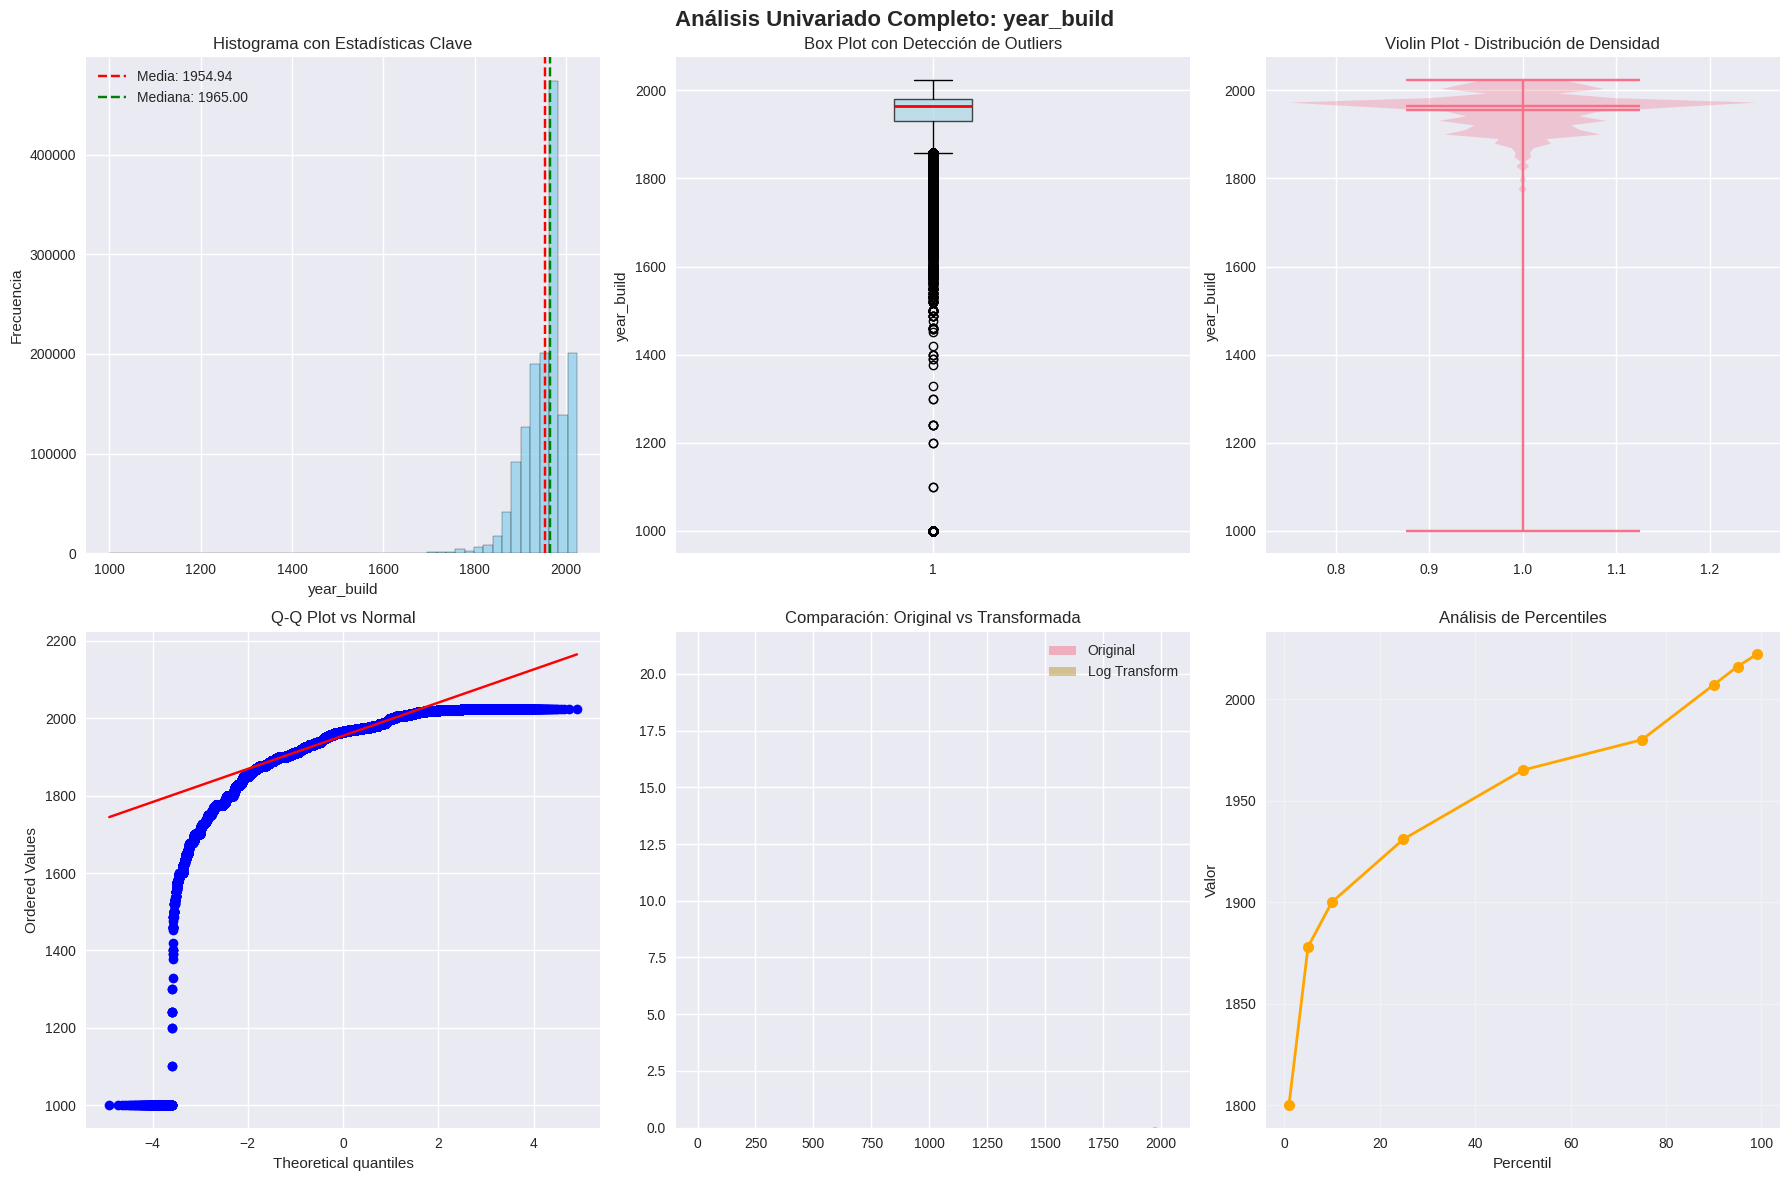


INSIGHTS DE NEGOCIO:
   • Concentración de datos: 0.10
     → El 80% de los datos se concentra en 10.4% del rango total

RECOMENDACIONES DE PREPROCESSING:
   • Considerar transformación para reducir asimetría:
     → Transformación exponencial o potencial


In [30]:
# Análisis detallado de year_build - Año de construcción
year_build_analysis = utils.enhanced_univariate_analysis(df_clean, 'year_build', 'numeric')


ANÁLISIS UNIVARIADO MEJORADO: NOM_INTEREST_RATE%

ESTADÍSTICAS DESCRIPTIVAS:
   • Observaciones: 1,506,713
   • Valores únicos: 31
   • Valores nulos: 0 (0.00%)
   • Mínimo: 0.00
   • Q1 (25%): 0.00
   • Mediana: 0.75
   • Q3 (75%): 3.25
   • Máximo: 9.50
   • Media: 1.68
   • Desviación estándar: 2.04

MEDIDAS DE FORMA:
   • Asimetría (Skewness): 1.342
     → Interpretación: Asimetría positiva (cola derecha)
   • Curtosis: 2.148
     → Interpretación: Leptocúrtica (más puntiaguda que normal)
   • Coeficiente de variación: 121.71%
     → Interpretación: Alta variabilidad

DETECCIÓN DE OUTLIERS (Método IQR):
   • Límite inferior: -4.88
   • Límite superior: 8.12
   • Total de outliers: 30,528 (2.03%)
   • Outliers más extremos:
     → 8.25
     → 9.50

TESTS DE NORMALIDAD:
   • Jarque-Bera Test:
     → Estadístico: 742265.917
     → p-valor: 0.000000
     → Resultado: No normal


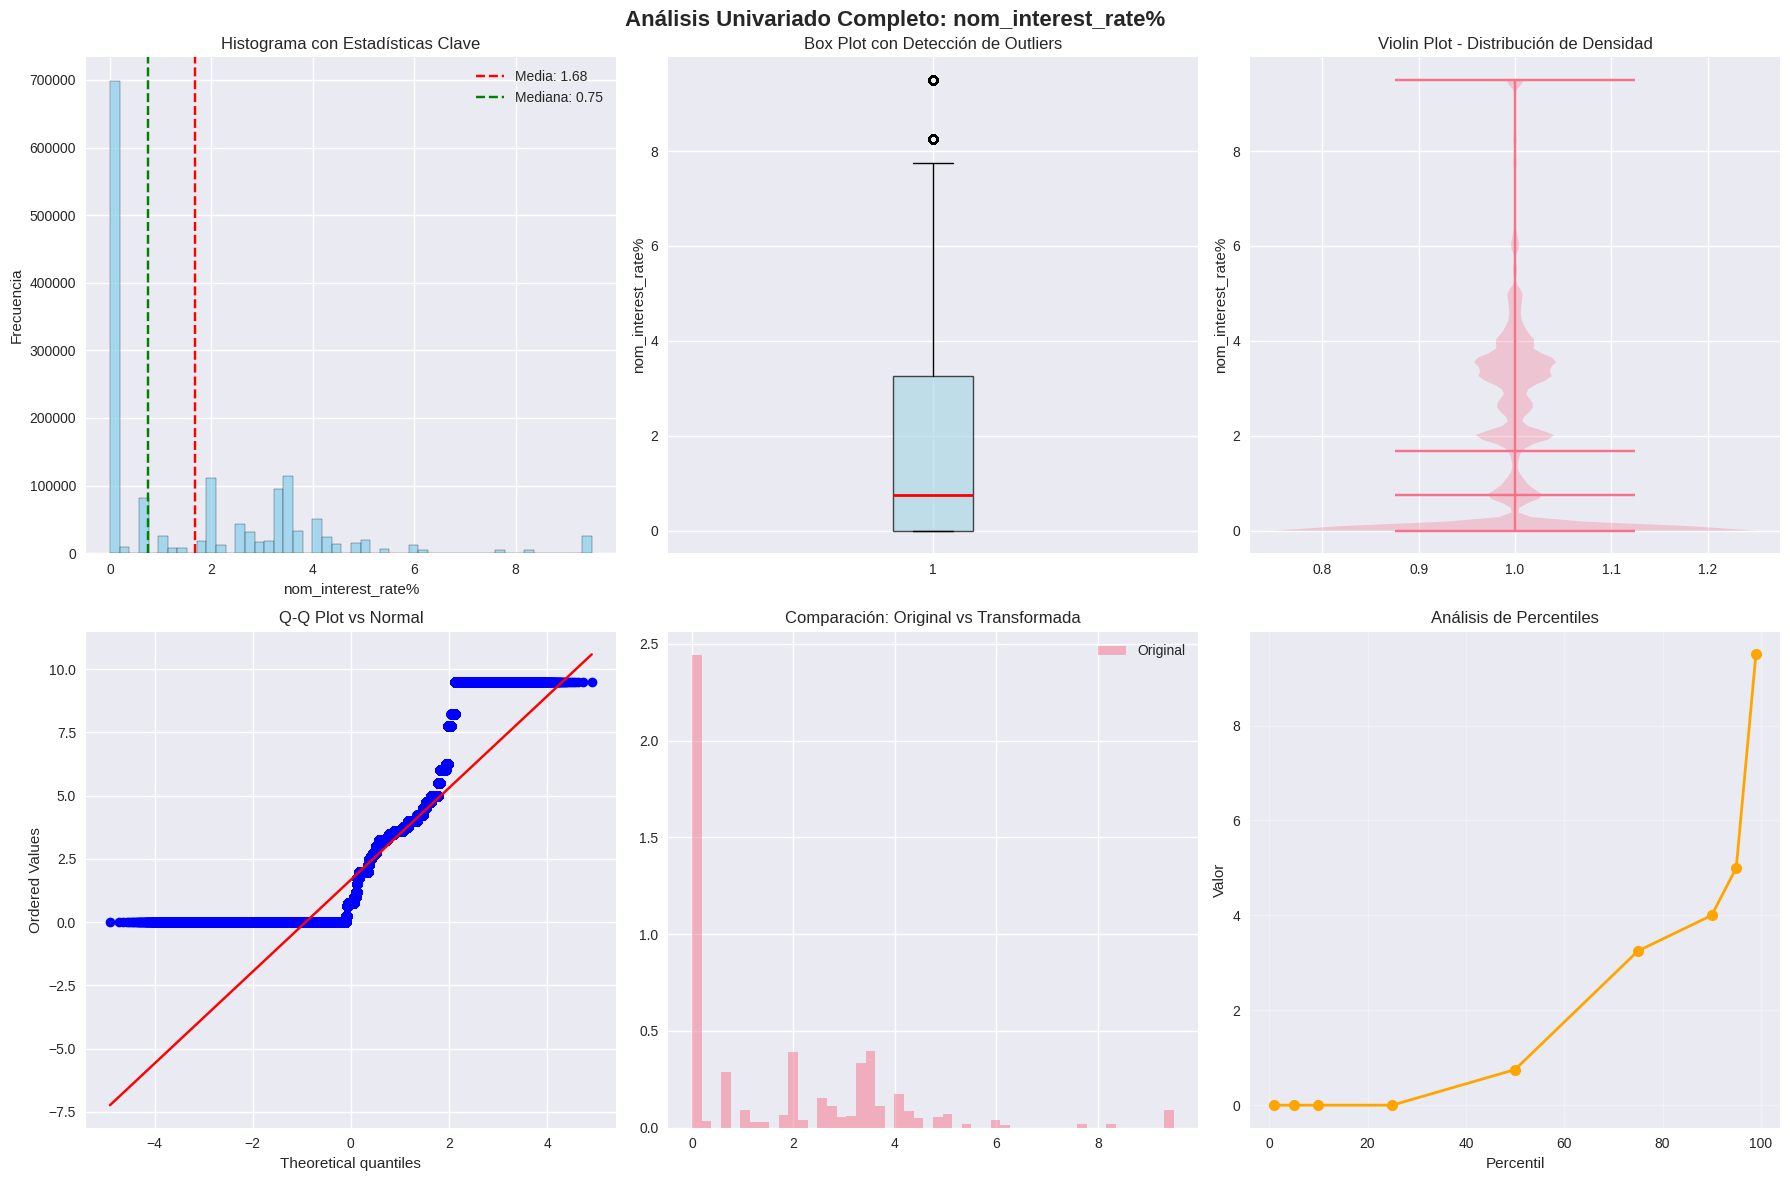


INSIGHTS DE NEGOCIO:
   • Concentración de datos: 0.42
     → El 80% de los datos se concentra en 42.1% del rango total
   • Alta variabilidad sugiere potencial para segmentación

RECOMENDACIONES DE PREPROCESSING:
   • Considerar transformación para reducir asimetría:
     → Transformación logarítmica, Box-Cox, o raíz cuadrada


In [31]:
# Análisis detallado de nom_interest_rate% - Tasa de interés nominal
interest_rate_analysis = utils.enhanced_univariate_analysis(df_clean, 'nom_interest_rate%', 'numeric')

## Análisis Detallado de Variables Categóricas

### Variables de Tipo y Ubicación


ANÁLISIS UNIVARIADO MEJORADO: SALES_TYPE

ESTADÍSTICAS DESCRIPTIVAS:
   • Observaciones: 1,506,713
   • Valores únicos: 5
   • Valores nulos: 0 (0.00%)
   • Moda: regular_sale
   • Concentración en categoría principal: 88.39%
   • Índice de diversidad (Shannon): 0.453

DISTRIBUCIÓN DE CATEGORÍAS:
   • regular_sale: 1,331,802 (88.39%)
   • family_sale: 121,144 (8.04%)
   • other_sale: 36,645 (2.43%)
   • auction: 17,103 (1.14%)
   • -: 19 (0.00%)


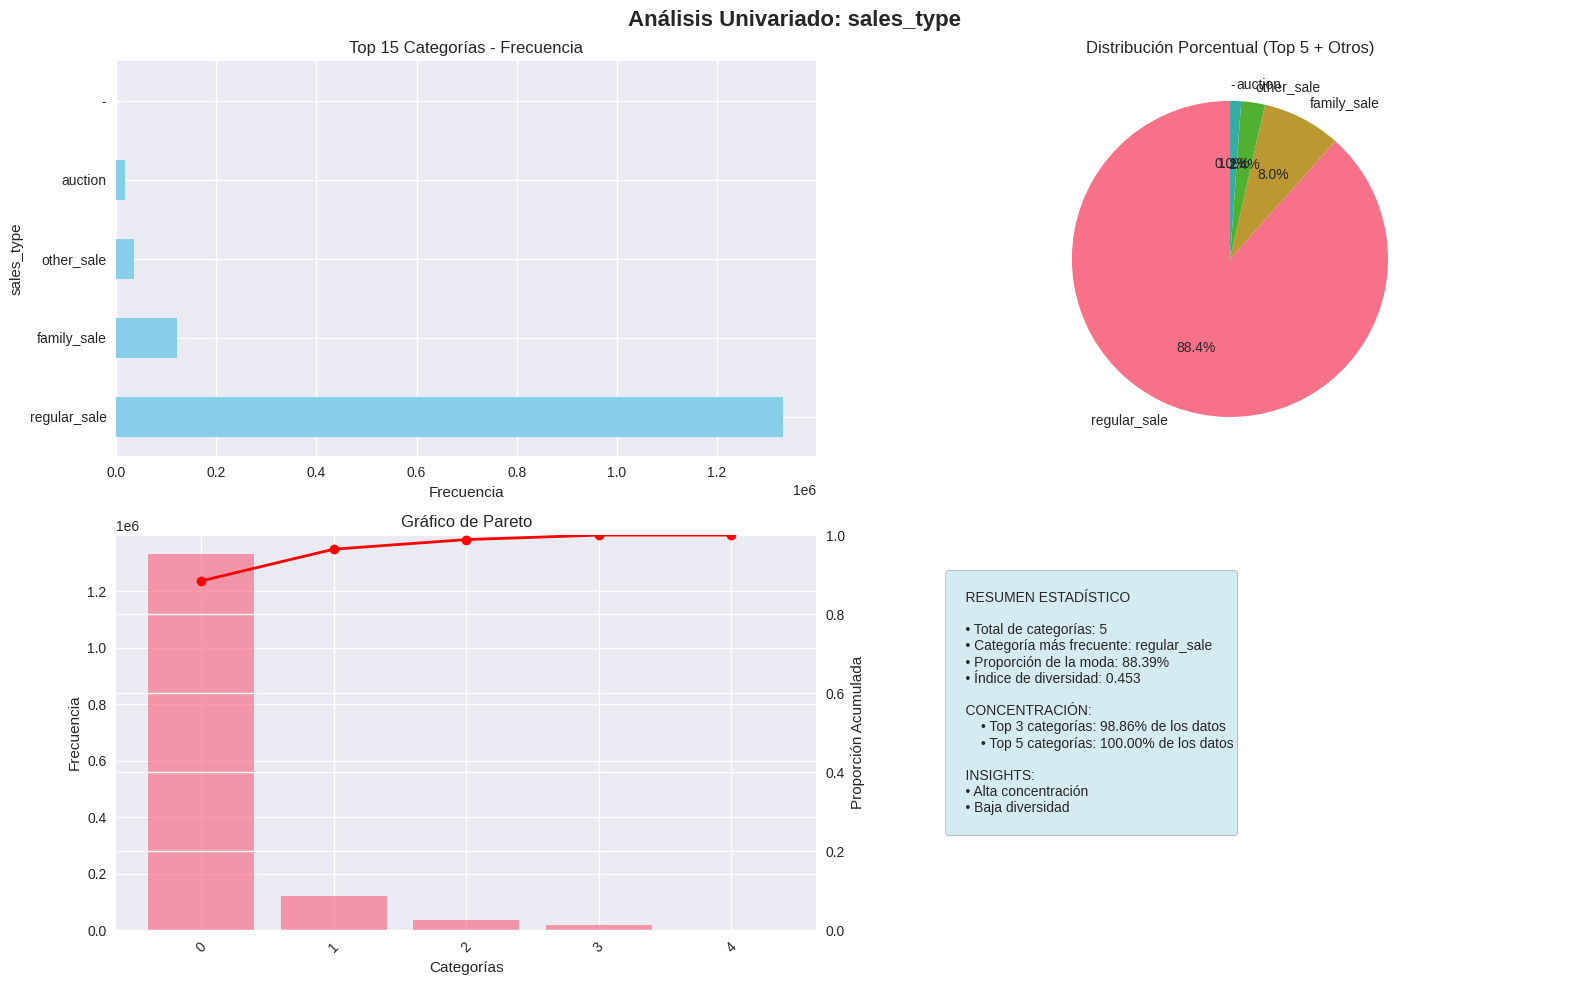


INSIGHTS DE NEGOCIO:
   • Extrema concentración en una categoría - verificar calidad de datos


In [32]:
# Análisis detallado de sales_type - Tipo de venta
sales_type_analysis = utils.enhanced_univariate_analysis(df_clean, 'sales_type', 'categorical')


ANÁLISIS UNIVARIADO MEJORADO: REGION

ESTADÍSTICAS DESCRIPTIVAS:
   • Observaciones: 1,506,713
   • Valores únicos: 4
   • Valores nulos: 0 (0.00%)
   • Moda: Jutland
   • Concentración en categoría principal: 50.13%
   • Índice de diversidad (Shannon): 0.980

DISTRIBUCIÓN DE CATEGORÍAS:
   • Jutland: 755,305 (50.13%)
   • Zealand: 597,090 (39.63%)
   • Fyn & islands: 138,425 (9.19%)
   • Bornholm: 15,893 (1.05%)


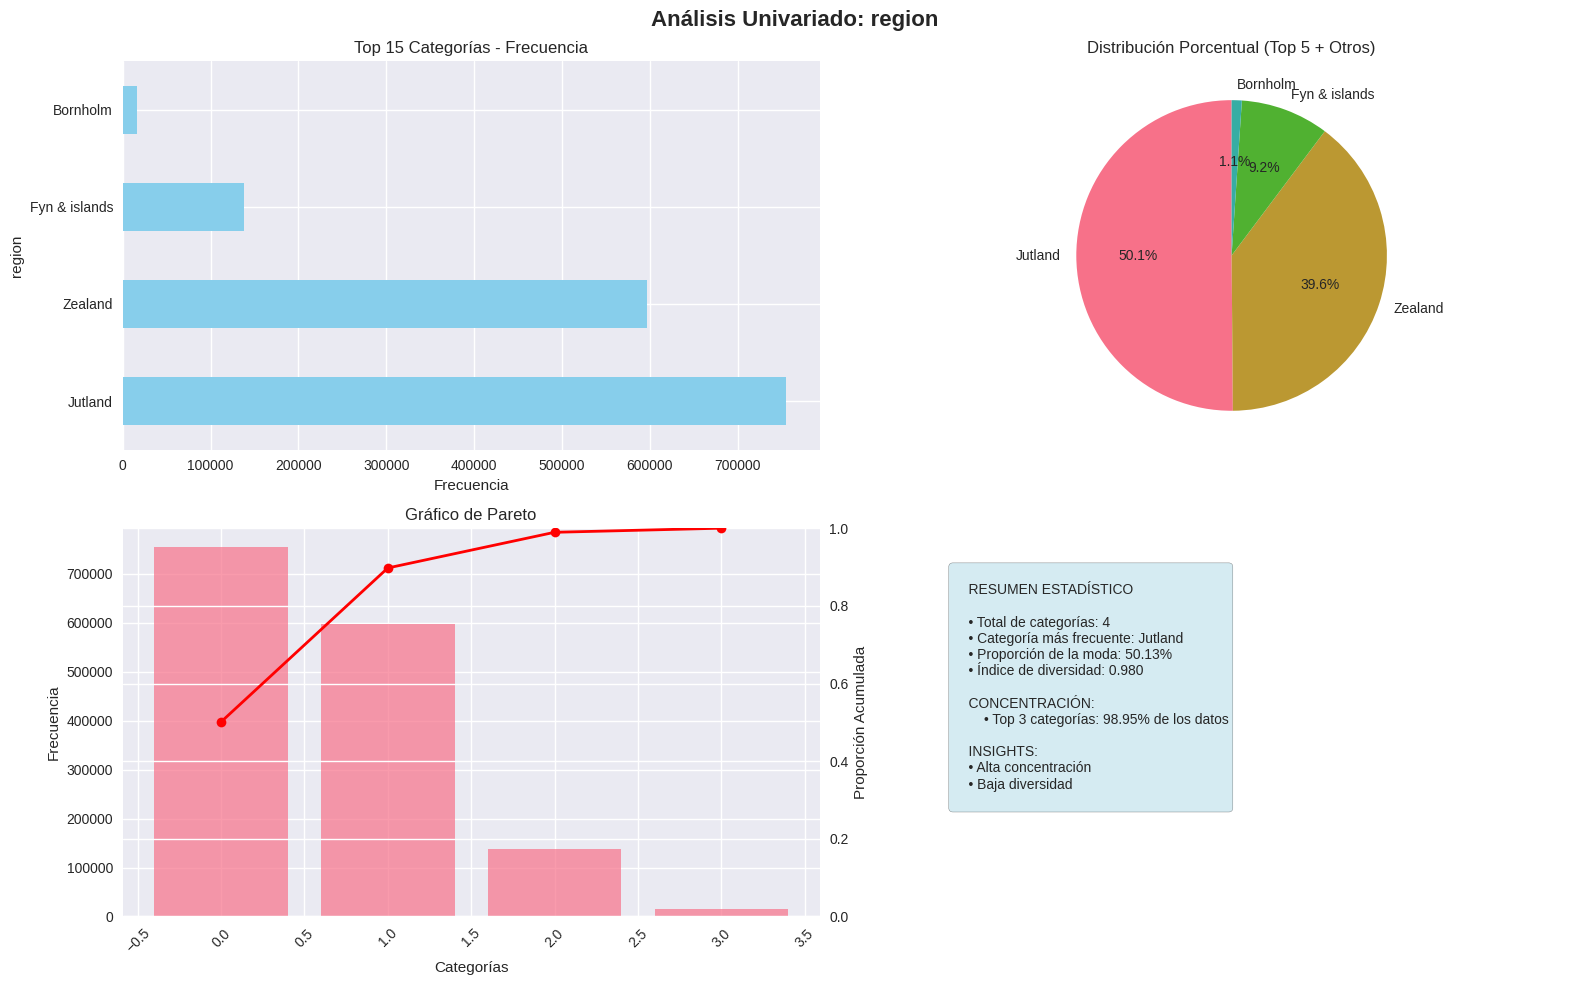


INSIGHTS DE NEGOCIO:
   • Alta concentración - considerar binning o agrupación


In [33]:
# Análisis detallado de region - Región geográfica
region_analysis = utils.enhanced_univariate_analysis(df_clean, 'region', 'categorical')

## Resumen Consolidado del Análisis Univariado

### Insights Clave y Recomendaciones Estratégicas

In [34]:
# Crear el resumen consolidado del análisis univariado
summary_results = utils.create_univariate_summary(df_clean)

RESUMEN CONSOLIDADO DEL ANÁLISIS UNIVARIADO

PANORAMA GENERAL DEL DATASET:
   • Total de observaciones: 1,506,713
   • Total de variables: 19
   • Variables numéricas: 11
   • Variables categóricas: 8

CALIDAD DE DATOS:
   • Variables con valores faltantes: 1
   • Porcentaje total de datos faltantes: 0.00%

ANÁLISIS DE VARIABLES NUMÉRICAS:
   • Variables con alta asimetría (|skew| > 1): 6
     → year_build: -2.72
     → purchase_price: 3.45
     → %_change_between_offer_and_purchase: -2.70
     → sqm: 1.79
     → sqm_price: 1.68
   • Variables que requieren transformación (|skew| > 2): 3
     → year_build: -2.72
     → purchase_price: 3.45
     → %_change_between_offer_and_purchase: -2.70

DETECCIÓN DE OUTLIERS:
   • Variables con >5% de outliers: 3
     → purchase_price: 82,688 outliers (5.5%)
     → %_change_between_offer_and_purchase: 159,068 outliers (10.6%)
     → sqm_price: 91,037 outliers (6.0%)

ANÁLISIS DE VARIABLES CATEGÓRICAS:
   • Variables con alta cardinalidad (>50 catego

DASHBOARD UNIVARIADO AVANZADO

RESUMEN GENERAL:
   • Variables numéricas: 11
   • Variables categóricas: 8
   • Total de observaciones: 1,506,713

1. ANÁLISIS DE DATOS FALTANTES
--------------------------------------------------


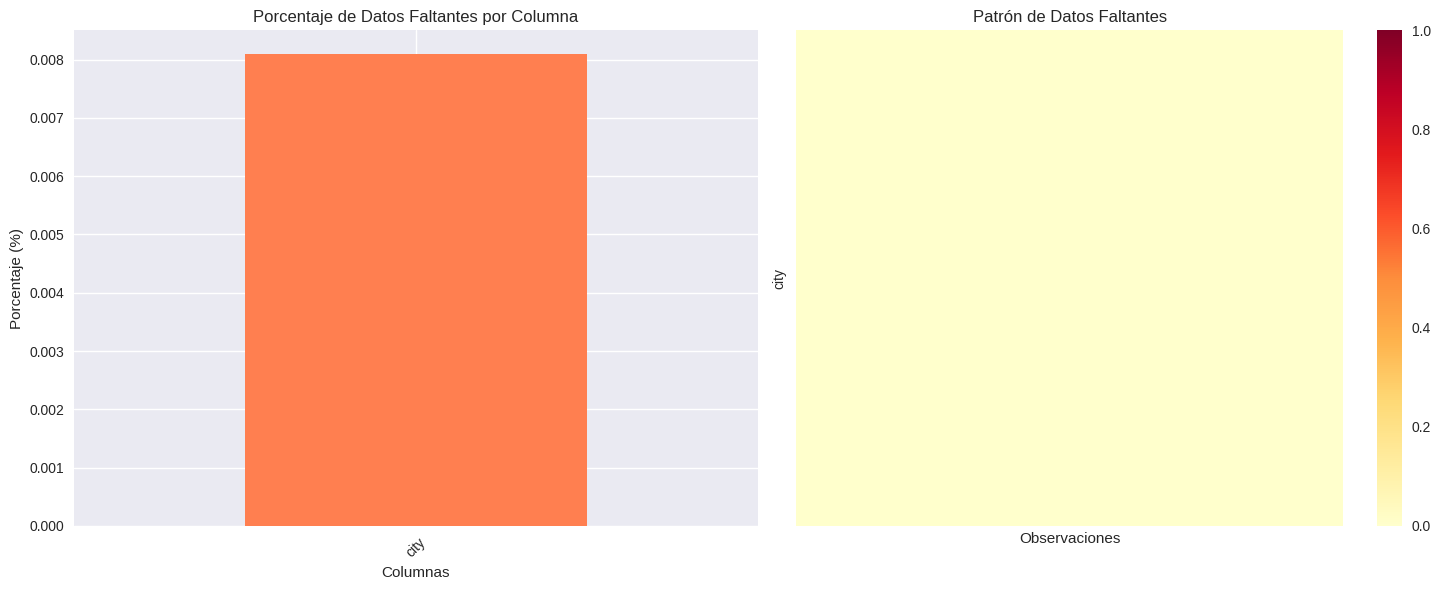


2. DISTRIBUCIONES NUMÉRICAS
--------------------------------------------------


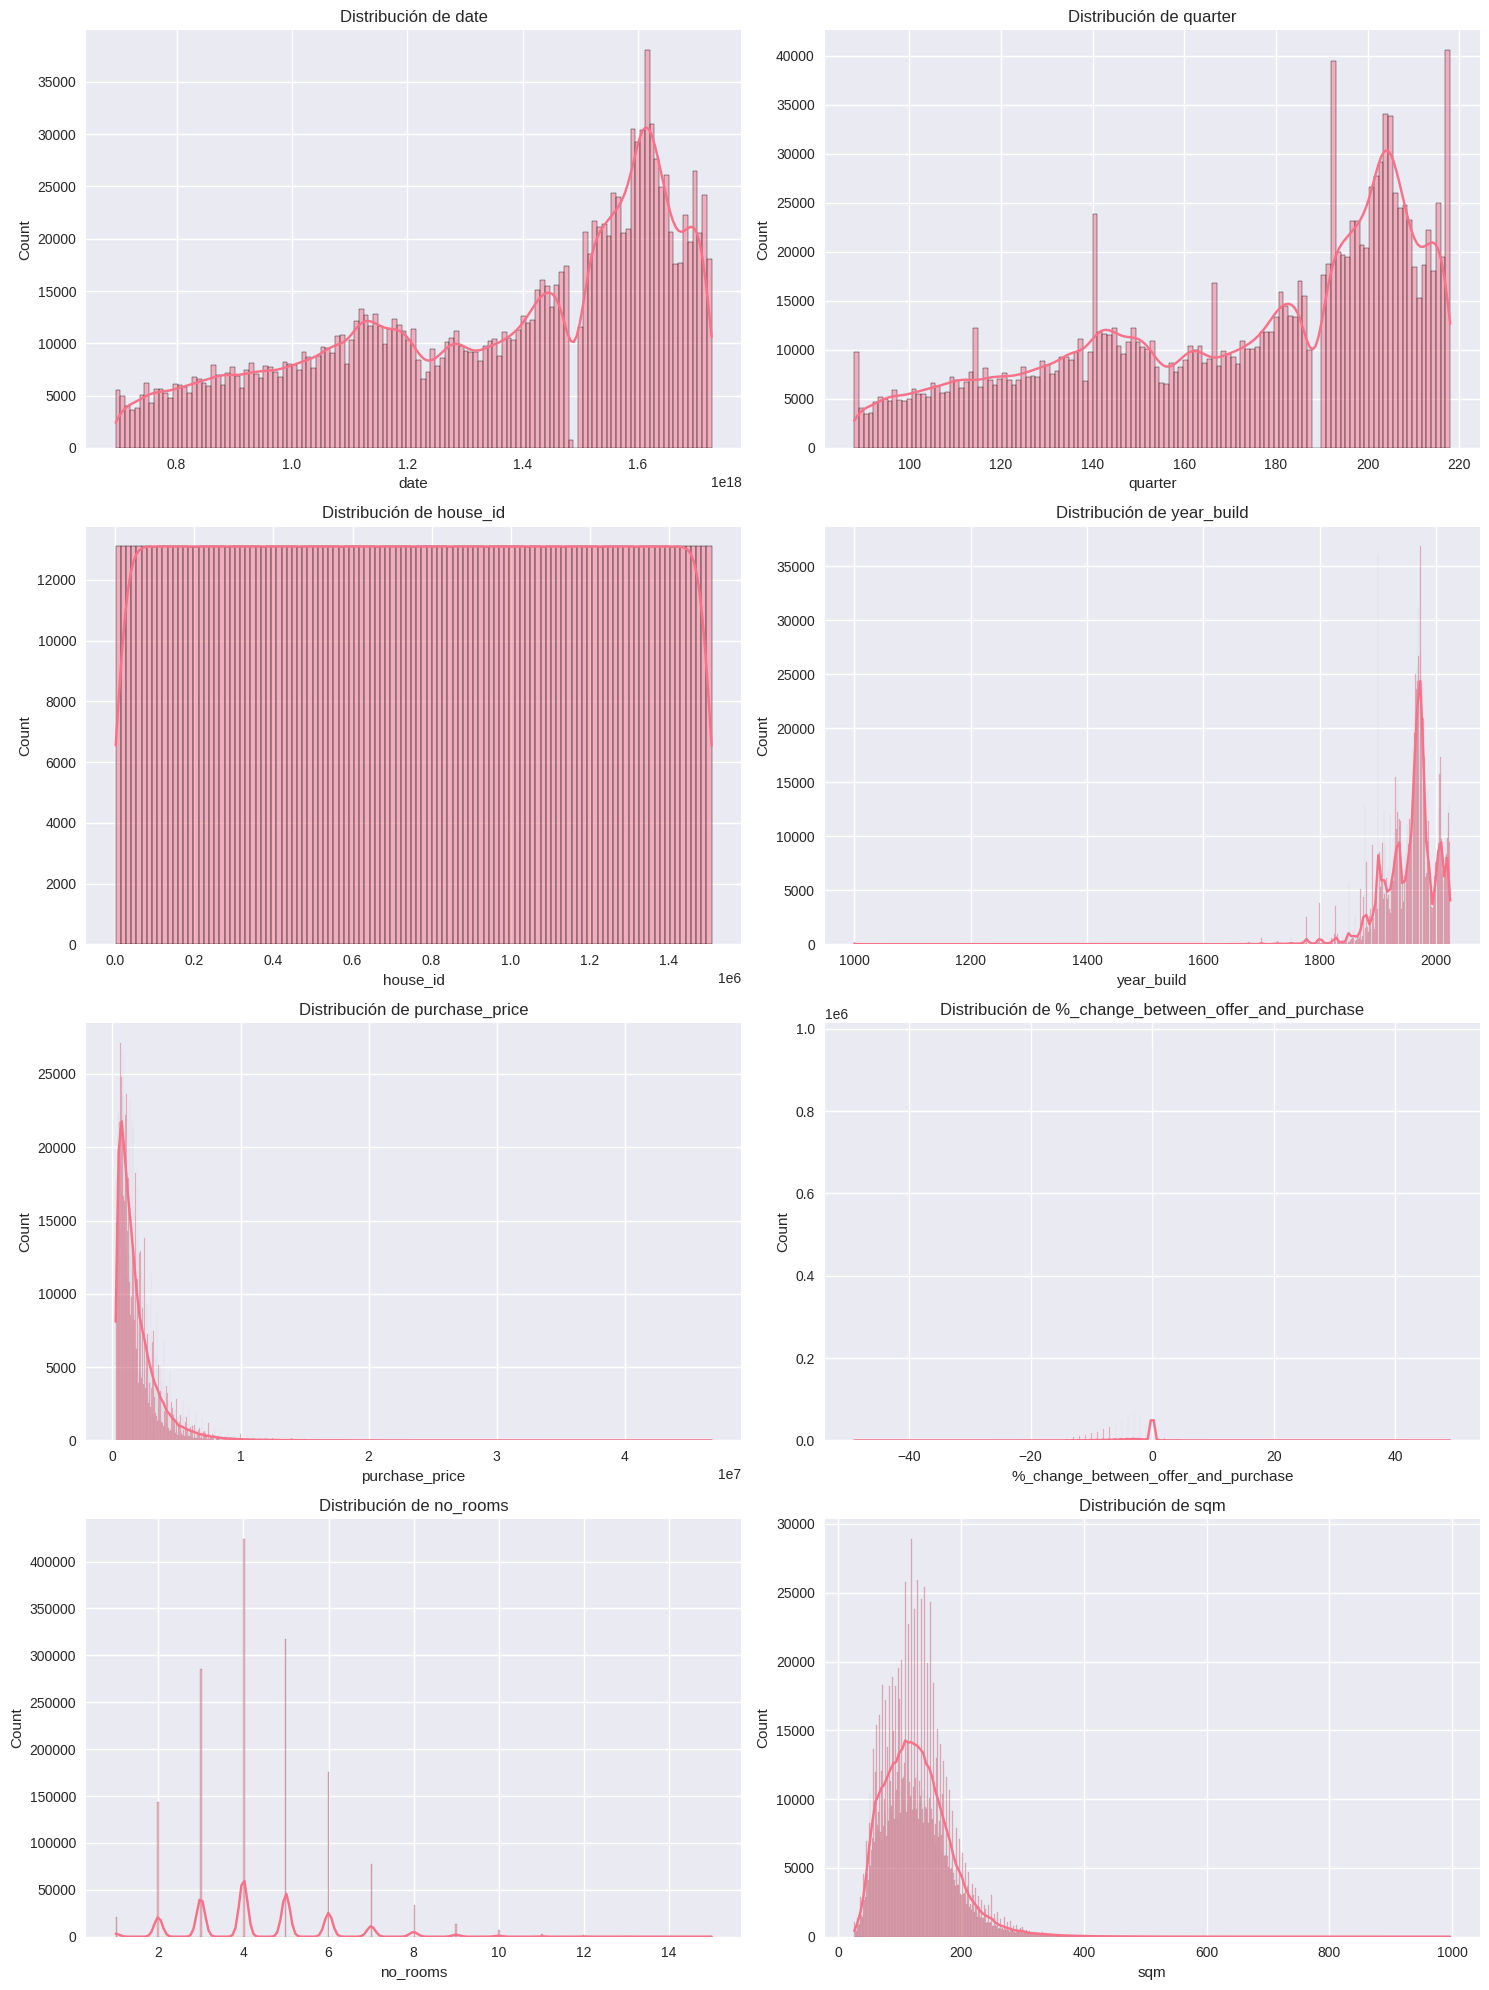


3. DETECCIÓN DE OUTLIERS
--------------------------------------------------


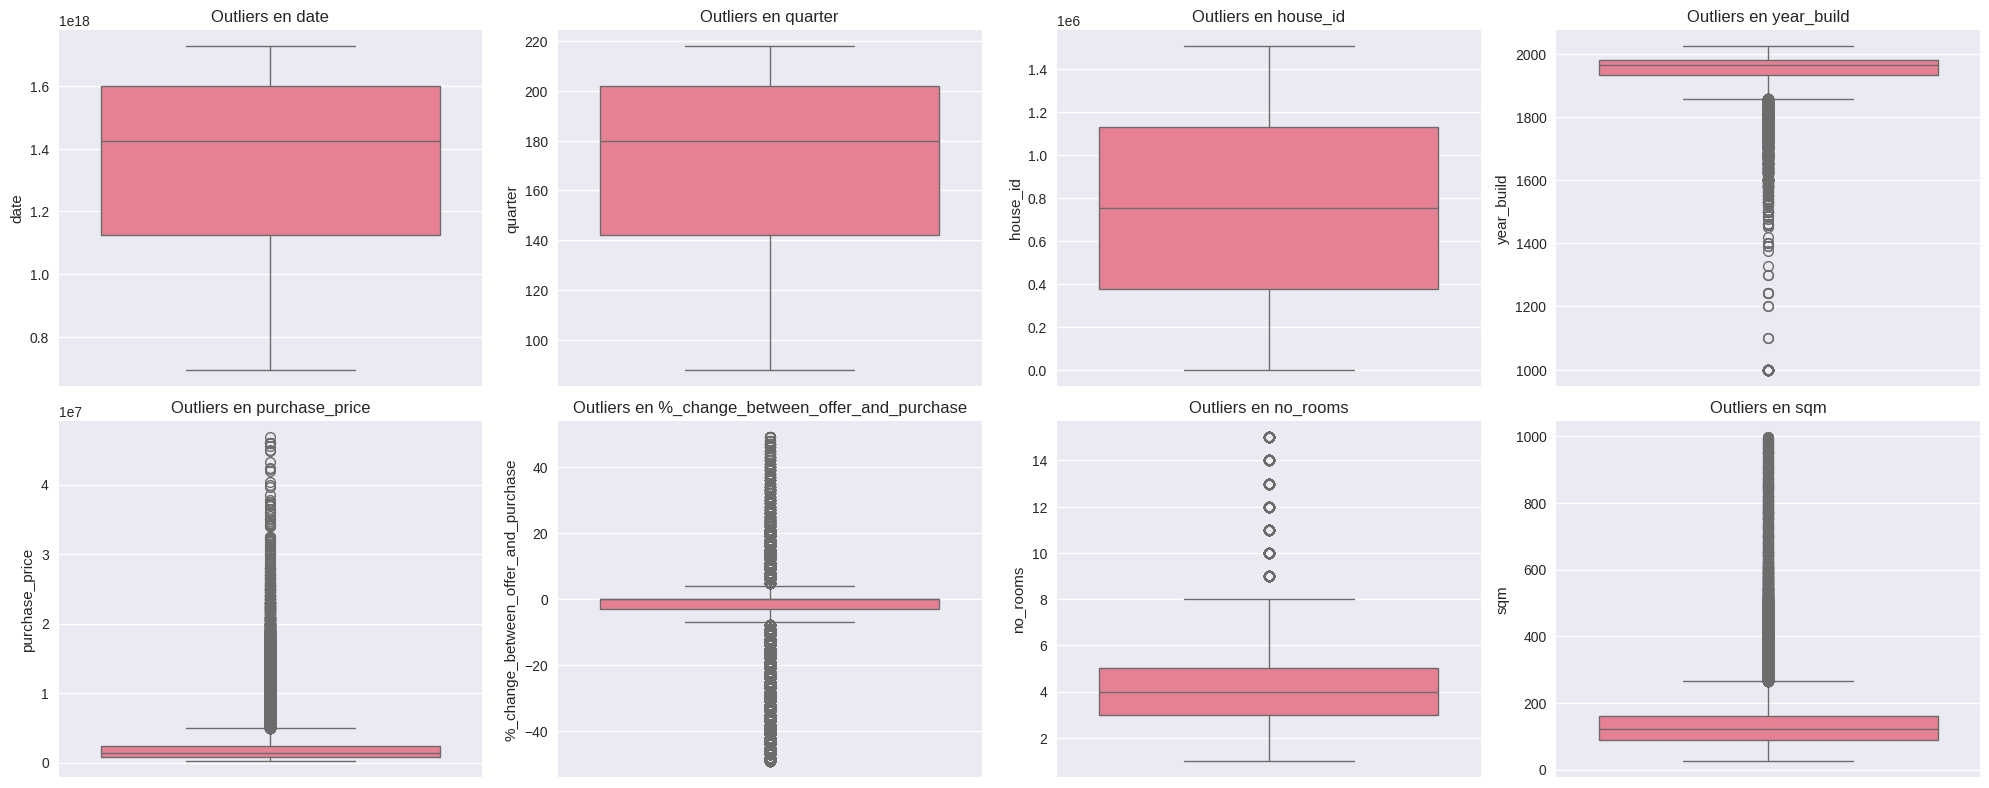


4. CORRELACIONES
--------------------------------------------------


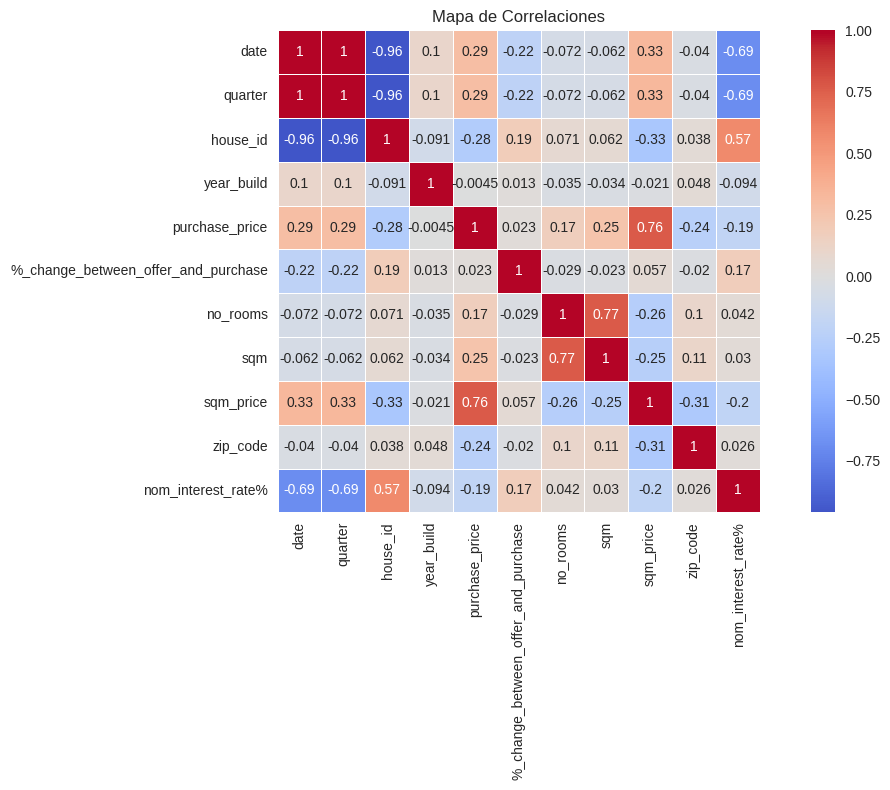


5. VARIABLES CATEGÓRICAS
--------------------------------------------------



DASHBOARD COMPLETADO


In [35]:
# Crear el dashboard avanzado de análisis univariado
utils.create_advanced_univariate_dashboard(df_clean)

## Conclusiones y Recomendaciones Finales

### Hallazgos Principales del Análisis Univariado

1. **Distribuciones de Precios**: Las variables relacionadas con precios muestran distribuciones asimétricas típicas del mercado inmobiliario
2. **Características Físicas**: Las propiedades muestran una amplia variabilidad en tamaños y características
3. **Patrones Geográficos**: Existe una concentración significativa en ciertas regiones
4. **Calidad de Datos**: El dataset presenta una buena calidad general con pocos valores faltantes

### Recomendaciones de Preprocessing

1. **Transformaciones Necesarias**:
   - Aplicar transformación logarítmica a variables de precio
   - Normalizar variables numéricas para modelos sensitivos a escala
   - Considerar binning para variables categóricas de alta cardinalidad

2. **Tratamiento de Outliers**:
   - Implementar técnicas de winsorizing para valores extremos
   - Considerar métodos robustos para outliers legítimos
   - Analizar outliers en contexto geográfico

3. **Feature Engineering**:
   - Crear variables derivadas (precio por m², antigüedad)
   - Agrupar categorías poco frecuentes
   - Considerar interacciones entre variables
